# Project Bridge: A Capstone Project to Address Data Fragmentation in the AEC Industry with AI-Powered Knowledge Retrieval

This Capstone Project stems from the [5-day Gen AI Intensive Course with Google](https://www.kaggle.com/learn-guide/5-day-genai) (March 31 - April 4, 2025). It explores applying core Gen AI capabilities taught in the course: like document/image understanding, Retrieval-Augmented Generation (RAG), structured outputs, and function calling—to tackle a real-world challenge in the Architecture, Engineering, and Construction (AEC) industry: creating a smart information retrieval system.

Accompanying this Kaggle Notebook are a [Medium blog post](https://medium.com/@junwang/bridging-the-gap-in-data-fragmentation-for-aec-a-capstone-project-on-ai-powered-knowledge-4907fed6c82b) diving into the why/what/how and use cases as well future opportunities, and a [YouTube video](https://www.youtube.com/watch?v=iwlgeVLrNbU) discussing the project's background, use cases, and future potential. 

Developed and written by: [Jun Wang, AI + Computational Design Lead, Associate at Gensler](https://www.linkedin.com/in/junwang0/) | [Tian Ouyang, Assoc. AIA, Associate at Gensler](https://www.linkedin.com/in/tian-ouyang-assoc-aia-ab558172/). Google’s Gemini 2.5 Pro model provided valuable help with text writing and editorial refining this notebook.

# Problem Statement

The Architecture, Engineering, and Construction (AEC) industry, projected to become a market exceeding $10 trillion by 2030 (_Oxford Economics, 2021_), **has consistently ranked among the least technologically innovative industries in the world**. McKinsey highlights structural barriers like "fragmentation... transient teams, and chronically low R&D spending" hindering tech adoption (McKinsey & Company, 2019).

Consequently, while AEC workflows generate vast data, an **estimated 96% goes unused** (FMI Corporation, 2018), often being siloed in disparate systems or buried in PDFs. This inefficiency is stark: professionals **waste 13% of their time just searching for information**, contributing to $88 billion in avoidable rework annually (Autodesk & FMI, 2021).

Could AI help bridge this data fragmentation? This project develops a proof-of-concept Retrieval-Augmented Generation (RAG) system tailored for AEC, aiming to connect buried insights with real-time needs and surface relevant knowledge effectively.

- [Autodesk & FMI (2021). Harnessing the Data Advantage in Construction](https://construction.autodesk.com/resources/guides/harnessing-data-advantage-in-construction/)
- [FMI (2018). Big Data = Big Questions](https://fmicorp.com/uploads/media/FMI_BigDataReport.pdf)
- [McKinsey (2019). Decoding Digital Transformation in Construction.](https://www.mckinsey.com/industries/engineering-construction-and-building-materials/our-insights/decoding-digital-transformation-in-construction)
- [Oxford Economics (2021). Future of Construction: Global Forecast to 2030.]( https://www.oxfordeconomics.com/wp-content/uploads/2023/08/Future-of-Construction-Full-Report.pdf)

# Proposed Solution

At its core, this project leverages **Retrieval-Augmented Generation (RAG)**. RAG systems uniquely combine the search power of vector databases with the generative capabilities of **Large Language Models** (LLMs). Instead of relying solely on generic training data, RAG grounds the LLM's responses in specific, relevant content retrieved from your own knowledge base. This dramatically reduces irrelevant or "hallucinated" answers, providing precise, context-aware information.

For AEC professionals, this opens up new possibilities. Instead of digging through folders or legacy PDFs, teams can now ask questions like _“What are five design strategies for reactivating retail corridors?”_ or _“Show me recent mixed-use projects with plaza-facing residential units,”_ and receive grounded, project-specific responses in seconds.

Recognizing that AEC knowledge is heavily visual, we extended this concept to **multimodal RAG**. Our system can retrieve and understand not just text, but also relevant diagrams, sketches, photos, and their associated context, providing a more holistic knowledge retrieval experience.

This proof-of-concept extends a standard RAG pipeline into a **multimodal, metadata-aware, and structured-response system** tailored for the complexities of the AEC industry.


| **Layer**                | **Tools & Technologies**                                                               | **Purpose**                                                                                                                    |
| ------------------------ | -------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| **LLM & Vision Models**  | gemini-2.0-flash: [Gemini (Google AI API)](https://ai.google.dev)                      | Natural language understanding, function calling, generative responses, and vision-based image captioning (OCR + description). |
| **Image Generation**     | gemini-2.0-flash-exp-image-generation: [Gemini (Google AI API)](https://ai.google.dev) | Generates AI-rendered images based on text prompts, captions, or related metadata.                                             |
| **Embedding Models**     | text-embedding-004: <br>[Gemini (Google AI API)](https://ai.google.dev)                | Converts text and image metadata into high-dimensional semantic vectors.                                                       |
| **Vector Database**      | [ChromaDB](https://www.trychroma.com)                                                  | Stores and indexes vectorized content for fast semantic search (dual collection: text & image).                                |
| **Retrieval Layer**      | Custom Retriever + Function Calling Wrapper                                            | Intelligently routes queries to the appropriate retrieval or generation tool.                                                  |
| **Data Sources**         | [Gensler Research Library](https://www.gensler.com/research-library)                   | Real-world AEC knowledge base for demonstration.                                                                               |
| **Data Pipeline**        | Python, Pandas, Gemini API                                                             | Extracts, cleans, enriches, and embeds text + image data.                                                                      |
| **Output Formatting**    | JSON → Markdown Renderer                                                               | Ensures structured, readable AI responses with custom citation and layout control.                                             |
| **Notebook Environment** | [Kaggle Notebooks](http://kaggle.com/)                                                 | Interactive development and public demonstration environment.                                                                  |


# Project Setup

Before starting, we’ll configure the environment by removing unnecessary packages and installing required libraries.

## Setup Steps:
- **Clean Up**: Remove unused/conflicting packages from Kaggle’s base image.
- **Install Dependencies**:
  - `google-generativeai`: Access the Gemini API.
  - `chromadb`: Vector storage for semantic search.
  - `langchain`: For future agentic workflows.
  - `python-frontmatter`: To parse markdown metadata.
  - `tqdm`: To provide progress bars for large-scale data processing.

In [28]:
# Remove conflicting/unused packages from the Kaggle base environment.
!pip uninstall -qqy jupyterlab kfp libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
# Install Google AI API
!pip install -qU "google-genai==1.7.0" "chromadb==0.6.3"
# Library to process markdown frontmatter for metadata
!pip install python-frontmatter 
#adding progress bar support
!pip install tqdm 

In [29]:
# import the google genai library and tools to support tweaking its configurations
from google import genai
from google.genai import types

# import Markdown for visualizing generated text in a structured and visualling pleasing way
from IPython.display import Markdown

# testing to confirm the correct version of genai is installed
genai.__version__

'1.7.0'

In [30]:
# load the API key
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

# Model Overview

## Embedding Model

We use the [`embedContent`](https://ai.google.dev/api/embeddings#method:-models.embedcontent) API to compute document embeddings before storing them in the database.

- Primary Model: `text-embedding-004` — the latest production embedding model.
- Alternative: `gemini-embedding-exp-03-07` (experimental).
- More info: [`models.list`](https://ai.google.dev/api/models#method:-models.list) | [Gemini API Models Guide](https://ai.google.dev/gemini-api/docs/models/gemini#text-embedding).

## LLM Model

We select `gemini-2.0-flash` for this project due to:
- High-speed generation and cost-efficiency.
- Long context window (up to 1 million tokens) — ideal for working with fragmented AEC documents.
- Multimodal input support for handling images and schematics.

In [31]:
client = genai.Client(api_key=GOOGLE_API_KEY)

for m in client.models.list():
    if "embedContent" in m.supported_actions:
        print(m.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [32]:
# Collect rows of model info
rows = [
    "| Model | Supported Actions |",
    "|-------|-------------------|"
]

for m in client.models.list():
    name = m.name
    actions = m.supported_actions

    is_embedding = "embedContent" in actions

    # Skip embedding models if desired
    if not is_embedding:
        actions_str = ", ".join(actions)
        row = f"| `{name}` | {actions_str} |"
        rows.append(row)

# Display the markdown table
display(Markdown("\n".join(rows)))

| Model | Supported Actions |
|-------|-------------------|
| `models/chat-bison-001` | generateMessage, countMessageTokens |
| `models/text-bison-001` | generateText, countTextTokens, createTunedTextModel |
| `models/embedding-gecko-001` | embedText, countTextTokens |
| `models/gemini-1.0-pro-vision-latest` | generateContent, countTokens |
| `models/gemini-pro-vision` | generateContent, countTokens |
| `models/gemini-1.5-pro-latest` | generateContent, countTokens |
| `models/gemini-1.5-pro-001` | generateContent, countTokens, createCachedContent |
| `models/gemini-1.5-pro-002` | generateContent, countTokens, createCachedContent |
| `models/gemini-1.5-pro` | generateContent, countTokens |
| `models/gemini-1.5-flash-latest` | generateContent, countTokens |
| `models/gemini-1.5-flash-001` | generateContent, countTokens, createCachedContent |
| `models/gemini-1.5-flash-001-tuning` | generateContent, countTokens, createTunedModel |
| `models/gemini-1.5-flash` | generateContent, countTokens |
| `models/gemini-1.5-flash-002` | generateContent, countTokens, createCachedContent |
| `models/gemini-1.5-flash-8b` | createCachedContent, generateContent, countTokens |
| `models/gemini-1.5-flash-8b-001` | createCachedContent, generateContent, countTokens |
| `models/gemini-1.5-flash-8b-latest` | createCachedContent, generateContent, countTokens |
| `models/gemini-1.5-flash-8b-exp-0827` | generateContent, countTokens |
| `models/gemini-1.5-flash-8b-exp-0924` | generateContent, countTokens |
| `models/gemini-2.5-pro-exp-03-25` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.5-pro-preview-03-25` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.5-flash-preview-04-17` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.0-flash-exp` | generateContent, countTokens, bidiGenerateContent |
| `models/gemini-2.0-flash` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.0-flash-001` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.0-flash-exp-image-generation` | generateContent, countTokens, bidiGenerateContent |
| `models/gemini-2.0-flash-lite-001` | generateContent, countTokens |
| `models/gemini-2.0-flash-lite` | generateContent, countTokens |
| `models/gemini-2.0-flash-lite-preview-02-05` | generateContent, countTokens |
| `models/gemini-2.0-flash-lite-preview` | generateContent, countTokens |
| `models/gemini-2.0-pro-exp` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.0-pro-exp-02-05` | generateContent, countTokens, createCachedContent |
| `models/gemini-exp-1206` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.0-flash-thinking-exp-01-21` | generateContent, countTokens |
| `models/gemini-2.0-flash-thinking-exp` | generateContent, countTokens |
| `models/gemini-2.0-flash-thinking-exp-1219` | generateContent, countTokens |
| `models/learnlm-1.5-pro-experimental` | generateContent, countTokens |
| `models/learnlm-2.0-flash-experimental` | generateContent, countTokens |
| `models/gemma-3-1b-it` | generateContent, countTokens |
| `models/gemma-3-4b-it` | generateContent, countTokens |
| `models/gemma-3-12b-it` | generateContent, countTokens |
| `models/gemma-3-27b-it` | generateContent, countTokens |
| `models/aqa` | generateAnswer |
| `models/imagen-3.0-generate-002` | predict |
| `models/gemini-2.0-flash-live-001` | bidiGenerateContent, countTokens |

# Data Preparation

We begin by loading a curated list of documents, which will form the foundation of our embedding database.

## Data Source

The documents are markdown articles sourced from the Gensler Dialogue Blog (2025).

**Important**: To use this notebook, be sure to add this dataset as an input in the Kaggle sidebar under “Input” → “Add Input”

👉 [Public Gensler Thought Leadership](https://www.kaggle.com/datasets/junwangzero/public-gensler-thought-leadership) 



For additional context and broader research materials, visit the [Gensler Research & Insight Archive](https://www.gensler.com/research-insights-search).

In [33]:
import os

dataset_name = "public-gensler-thought-leadership"
input_path = f"/kaggle/input/{dataset_name}"
all_files = []

# Directly walk through the single dataset folder
for root, dirs, files in os.walk(input_path):
    for file in files:
        all_files.append(os.path.join(root, file))


# Print total count and the list
print(f"Total number of files: {len(all_files)}\n")
for file_path in all_files:
    print(file_path)
Markdown('---')

Total number of files: 34

/kaggle/input/public-gensler-thought-leadership/The New Experiential Hybrid.md
/kaggle/input/public-gensler-thought-leadership/The Biggest Challenge to Office Conversions Isnt Design  Its the Status Quo.md
/kaggle/input/public-gensler-thought-leadership/Realizing the Value of Artificial Intelligence When Planning Tomorrows Healthcare Facilities.md
/kaggle/input/public-gensler-thought-leadership/Global Workplace Survey Comparison 2023.md
/kaggle/input/public-gensler-thought-leadership/Prototyping the Hospital of the Future.md
/kaggle/input/public-gensler-thought-leadership/Redefining the Workplace for a New Era of Productivity and Engagement.md
/kaggle/input/public-gensler-thought-leadership/Severe Weather The New Design Imperative.md
/kaggle/input/public-gensler-thought-leadership/The Uncertainty of Electric Power A View from Houston.md
/kaggle/input/public-gensler-thought-leadership/Biodiversity as the New Frontier for Achieving Resilience in Real Estate.md


---

## Preview: Sample Article Format

Below is how a sample article is structured prior to preprocessing.

In [34]:
# helper function to parse input markdown files
def read_markdown(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read()

# Read all markdown files into a list of strings
documents = [read_markdown(path) for path in all_files]

print(documents[0][:800])  # Preview first 500 characters of the first doc
Markdown('---')

---
title: "The New Experiential Hybrid"
source: "https://www.gensler.com/blog/the-new-experiential-hybrid"
author:
  - "[[Gensler]]"
published:
created: 2025-04-09
description: "Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME."
tags:
  - "clippings"
---
![A street with cars and buildings.](https://static2.gensler.com/uploads/image/96476/Sportsmens_Lodge_N7_1738969737.jpg)

The Sportsmen’s Lodge, Los Angeles, California

The convergence of our physical and digital ecosystems continues to revolutionize our lives, reshape our behaviors, and reimagine our ability to navigate the complex beauty and challenges of life in a boundaryless world. Radical technological innovations have resulted 


---

## Article Parsing & Cleaning

In this step, we process each markdown article to prepare it for embedding and retrieval. Key actions include:

- Extracting metadata from the frontmatter to populate the vector database.
- Replacing raw frontmatter with a readable table for better presentation.
- Converting image links into rich descriptions using multimodal prompting (e.g., caption + OCR).
- Generating reverse prompts via Gen AI, which can be used for fine-tuning or few-shot learning.

In [35]:
from google.api_core import retry

# Define a helper to retry when per-minute quota is reached.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

## Image Understanding & OCR

We will now define a function that loads an image from a URL and generates a rich description using a multimodal LLM. This includes object detection, layout interpretation, and OCR (text extraction), enabling the model to extract all relevant visual and textual information from the image.

In [36]:
import PIL.Image
import requests

# set up a function that returns the description of an image from a given url
def describe_image_from_url(image_url, client, model_name="gemini-2.0-flash"):
    """
    Downloads an image from a URL, sends it to Gemini for description,
    and returns a one-sentence description string.
    """
    # Extract filename from URL
    filename = image_url.split("/")[-1]
    
    # Download image
    response = requests.get(image_url, stream=True)
    if response.status_code != 200:
        return f"[Could not retrieve image: {image_url}]"
    
    with open(filename, "wb") as f:
        f.write(response.content)

    # Open image
    image = PIL.Image.open(filename)

    # Prepare prompt
    prompt = [
        #"What is this? Please describe it. Only give me the detailed description in one single sentence, DO NOT tell me anything else.",
        """Describe this image in as much detail as possible, 
        including all visible objects, text (perform OCR), 
        spatial relationships, colors, context clues, 
        and any other relevant visual information. 
        Be sure to also include information such as:
        types of image: whether it's a photo, rendering, data visualization graphics, etc.;
        if it's a data visualization or contains data, please really recognize all numbers, text, data from the image and translate into complete sentences;
        types of view (can be multiple): aerial, eye level, building exterior, building interior;
        types of design descipline (can be multiple): architecture, interior, urban planning/design, branding, digital experience, etc.;
        times of day and generate lighting condition: day, night, bright, dark, etc.;
        types of design style: modern, industrial, minimalist, mid-century modern, soft, welcoming, energetic, etc.;
        general material and color palette summary: is it warm? does it have wood, textile, stone, etc.;
        Only provide 1 to 5 comprehensive sentences.""",
        image,
    ]

    # Get description from Gemini
    gemini_response = client.models.generate_content(
        model=model_name,
        contents=prompt
    )
    
    # Clean up file
    os.remove(filename)

    return gemini_response.text.strip()

We will test the effectiveness of the image description function in capturing both visual details and embedded text (OCR). This helps validate its usefulness for searching and retrieving visual content in a semantic search system.

In [37]:
from IPython.display import Image, display
#testing the function
image_url = "https://static2.gensler.com/uploads/image/96555/EdelmanLA2023_GobutyRyan_07_1739474705.jpg"
description = describe_image_from_url(image_url, client)

display(Image(url=image_url, width=800))
print(description)

This is a well-lit, eye-level interior photograph showcasing a modern and inviting office space with elements of architecture and interior design. The design style features a blend of modern and soft aesthetics with a warm material palette, incorporating wood and textiles. In the foreground, a man and a woman are seated at a dark, glossy oval table with a beige decorative bowl, while other people are seen working in enclosed, glass-walled office spaces in the background; the space is decorated with a long beige couch with various pillows, plants near a window, exposed ductwork and piping, and a unique neon light fixture. A woman in white pants and red shoes is entering one of the enclosed office spaces.


In [38]:
image_url = "https://static1.gensler.com/uploads/image/96027/CATD-blog-1_1_1736980989.jpg"
description = describe_image_from_url(image_url, client)

display(Image(url=image_url, width=800))
print(description)

This image is a data visualization graphic, specifically a donut chart, displaying the breakdown of total building carbon emissions; it is a digital experience design piece. The chart indicates that 42% of total building carbon emissions come from total building emissions, 15% from embodied carbon, 27% from building operational carbon, 28% from industry, 22% from transport, and 8% from other sources. The color palette is cool, utilizing shades of blue, green, and gray. The chart is set against a white background, giving it a clean and minimalist appearance.


In [39]:
image_url = "https://static1.gensler.com/uploads/image/96189/AssemblyFoodHall_N2_1738017152.jpg"
description = describe_image_from_url(image_url, client)

display(Image(url=image_url, width=800))
print(description)

This eye-level architectural photograph depicts a vibrant urban street scene at dusk, likely designed with branding and urban planning in mind, where modern architectural styles are mixed with industrial accents. Several restaurants and food establishments line the street, including "Sixty Vines," "Restaurante," "Boqueria," "Shake Shack," and "Assembly Food Hall," each denoted by illuminated signage. The buildings, primarily constructed with brick and glass, are adorned with neon signs, creating a bright and energetic atmosphere. The overall color palette is warm, with a mix of materials like brick, concrete, and metal contributing to a welcoming and lively ambiance.


In [40]:
image_url = "https://static2.gensler.com/uploads/image/85381/Global-WPS-Survey2023_WebBodyImages-3%20%281%29_1686587455.jpg"
description = describe_image_from_url(image_url, client)

display(Image(url=image_url, width=800))
print(description)

The image is a data visualization graphics, specifically a workplace survey comparison from 2023 by Gensler Research Institute. It presents data on the impact of choice in the workplace on effectiveness and experience. Three circular graphics represent different aspects: 73% of people have choice in where to work; 88% of office workers in the highest performing workplaces have choice; 81% of office workers who report having a great experience have choice. The first graph has gray bars from years 2016 to 2023 with 2023 being the largest bar. The graphic uses a warm color palette with earth tone colors and white as background.


## Embedding Visual Content as Text

In the parsed version of each article, we replace image links with AI-generated descriptions from Gemini. This allows us to extract the semantic content of the image as plain text, which can then be embedded using our text-only model. As a result, visual content becomes searchable alongside written content within the vector database.

In [41]:
# Replace image links in markdown with Gemini-generated descriptions

import re
import time

def replace_image_links_with_descriptions(markdown_text, client, delay=5.0):
    """
    Replaces image markdown with descriptions from Gemini and extracts metadata.
    """
    image_data = []

    # Pattern to find image markdown and possible one-line caption right below
    # Captures the entire match so we can do contextual replacement
    pattern = re.compile(
        r"!\[(.*?)\]\((https?://[^\s]+?)\)\n+([^\n]{1,200})?(?:\n|$)?",  # Group 3 is the caption if any
        re.MULTILINE # so pattern works line-by-line
    )

    def describe_and_replace(match):
        alt_text = match.group(1)
        image_url = match.group(2)
        caption = (match.group(3) or "").strip()

        try:
            description = describe_image_from_url(image_url, client)
        except Exception:
            description = alt_text  # fallback

        combined_text = f"{caption} — {description}" if caption else description

        image_data.append({
            "image_url": image_url,
            "alt_text": alt_text,
            "caption": caption,
            "generated_description": description
        })
        
        if delay >0:
            time.sleep(delay)

        # Replace with new markdown using the description
        return f"![{combined_text}]({image_url})\n{caption}\n" if caption else f"[{description}]({image_url})\n"
    
    # Perform substitution
    updated_text = pattern.sub(describe_and_replace, markdown_text)

    #time.sleep(delay)
    return updated_text, image_data

## Sample Test: Article Processing

We’ll now run our processing pipeline on a sample document to validate the metadata extraction, image parsing, and content enrichment steps.

In [42]:
# Test on a single markdown document
sample_doc = documents[0]  # or replace with a specific markdown string

# Run the replacement
updated_markdown, image_metadata = replace_image_links_with_descriptions(sample_doc, client)

# Print results
print("Updated Markdown:\n")
print(updated_markdown)

print("\nExtracted Image Metadata:\n")
for i, img in enumerate(image_metadata, 1):
    print(f"Image {i}:")
    for key, value in img.items():
        print(f"  {key}: {value}")
    print()

Updated Markdown:

---
title: "The New Experiential Hybrid"
source: "https://www.gensler.com/blog/the-new-experiential-hybrid"
author:
  - "[[Gensler]]"
published:
created: 2025-04-09
description: "Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME."
tags:
  - "clippings"
---
![The Sportsmen’s Lodge, Los Angeles, California — This is an eye-level photograph of a modern outdoor shopping center at dusk. The palm trees that line the pedestrian walkway are adorned with small white lights, creating a festive and inviting atmosphere. On either side of the walkway are modern buildings with large glass windows and dark wood accents; one building is clearly identified with the text "EREWHON." Several cars are parked along the street at the edge of the shopping center, and people are walking through the area and enjoying the outdoor seating areas of the restaurants. The overall design aesthetic

## Frontmatter Cleanup

To improve readability, we convert the article frontmatter into a structured markdown table format.  
Both the original (raw) and cleaned (parsed) versions of each document are saved separately to support different use cases—such as raw data retrieval or formatted display.

In [43]:
import pprint
import frontmatter
from tqdm import tqdm

# Helper function to translate metadata to a table
def metadata_to_table(metadata):
    lines = ["| Metadata | Value |", "|-----|-------|"]
    for key, value in metadata.items():
        lines.append(f"| {key} | {repr(value)} |")
    return '\n'.join(lines)

metadatas = []
parsed_docs = []
image_metadatas = []
original_docs = []

# Extract metadata in the original document and turn into clean table format
for doc in tqdm(documents, desc="📄 Parsing documents"):
    post = frontmatter.loads(doc)
    metadata = post.metadata
    metadatas.append(metadata)

    # Generate metadata table
    table = metadata_to_table(metadata)
    title = metadata.get('title', 'Untitled')
    parsed = f"{table}\n\n# {title}\n{post.content}"    

    # Replace image and capture output and image metadata
    parsed_with_descriptions, image_data = replace_image_links_with_descriptions(parsed, client)

    original_docs.append(parsed)  # Store unmodified version
    parsed_docs.append(parsed_with_descriptions) # Store modified version
    image_metadatas.append(image_data) # Store image metadata

display(Markdown(parsed_docs[0]))  # Preview an example of a parsed 
pprint.pprint(image_metadatas[0])
display(Markdown('---'))

📄 Parsing documents: 100%|██████████| 34/34 [13:14<00:00, 23.37s/it]


| Metadata | Value |
|-----|-------|
| title | 'The New Experiential Hybrid' |
| source | 'https://www.gensler.com/blog/the-new-experiential-hybrid' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 9) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |

# The New Experiential Hybrid
![The Sportsmen’s Lodge, Los Angeles, California — The image is a photograph taken from an eye-level view, depicting an outdoor shopping area at dusk, indicative of architecture and urban design. Palm trees wrapped with string lights illuminate the pedestrian walkway lined with modern buildings, one of which features a store called "EREWHON" with a brown and dark grey exterior. Cars are parked along the street, and people can be seen strolling through the plaza and sitting at outdoor cafe tables, creating a soft and welcoming atmosphere. The material palette consists of wood and glass, with a color scheme of warm lighting against a cool, twilight sky.](https://static2.gensler.com/uploads/image/96476/Sportsmens_Lodge_N7_1738969737.jpg)
The Sportsmen’s Lodge, Los Angeles, California

The convergence of our physical and digital ecosystems continues to revolutionize our lives, reshape our behaviors, and reimagine our ability to navigate the complex beauty and challenges of life in a boundaryless world. Radical technological innovations have resulted in a fundamental mindset shift of our behaviors, needs, and desires, moving from Live, Work, Play (and Shop), to a hybrid of **Live, Live, Live**.

While many of us feel Covid-19 is largely in the rearview mirror, unfortunately a tapestry of global social epidemics still affects us all. Americans are lonelier than ever: [according to the Cigna U.S. Loneliness Index](https://newsroom.thecignagroup.com/loneliness-epidemic-persists-post-pandemic-look), 58% of adults, and 79% of those aged 18-24 report being lonely. Our social networks are a third smaller now and we’re far more likely to live alone; today, nearly 28% of U.S. homes have just one occupant, up from 17% in 1969 according to the US Census. The annual number of marriages is in decline, and birth rates are slowing. In a lonelier, more divided world, the need for community is greater than ever.

There’s a lot to consider with this cascade of change occurring at the speed of culture. As landlords, developers, and designers collaborate for a better future, we need to start thinking differently. It is not enough to simply evolve the concept of our built environment. Since we now live a hybridized life, we need to make a transformative shift to a “New Hybrid” experience, one that can play a significant role in restoring our sense of closeness in our communities. The New Hybrid experience is a model that uses an integrative approach to the disciplines of art, science, and technology, helping us to develop a deeper understanding of the complexities of our modern world and guide us to produce positive and impactful outcomes.

The New Hybrid experience brings together the robust attributes of commerce, culture, and leisure, and recalibrates the urban experience. It is amenity rich, leverages technology, connects easily to transit, and offers world-class leisure and event activities. It promotes local artisans and culture, reflects generational and community values, and builds traditions.

We relate to urban environments in an emotional dimension. Signature characteristics of hybrid places — otherwise called mixed use — are personable and human-centric. The value proposition is when a space, a place, a building, or an event **moves** us. When this happens, it elicits a sense of awe and wonder, engages all of our senses, dissolves barriers, and eliminates pain points.

The emotional exchange between the built environment and the user is about attaining and retaining a person’s attention. It’s that visceral moment when something inside you connects with the place in a special way, the beyond ordinary life experience that can elicit an emotional response that requires no specialized knowledge, nothing more than one’s emotion to make it happen. And it happens to everyone. Great places have a defined persona, which has the ability to trigger aesthetic emotions — that highly emotive sense you get, which can sometimes be difficult to describe, but you just know it just feels amazing.

Here are some examples of how the New Hybrid is playing out in our project work across multiple scales:

For [The Hub on Causeway](https://www.gensler.com/projects/the-hub-on-causeway), a dynamic, 2-million-square-foot mixed-use development at Boston’s TD Garden, Gensler created a marquee sports and entertainment destination with office, residential, hotel, retail, entertainment, dining, and creative office space that culminates in a grand entrance that funnels people to TD Garden and the North Station transit hub.

![The Hub on Causeway, Boston, Massachusetts. Photo by Anton Grassl. — This eye-level photograph, likely taken at dusk, showcases the urban architecture and vibrant atmosphere of TD Garden and North Station in Boston. The image captures the illuminated "TD GARDEN" and "NORTH STATION" signage above a structural framework, leading to a bustling pedestrian area with escalators. The modern building behind features numerous warmly lit windows, contrasting with the cool blue tones of the sky. Street signs indicating "CANAL ST" and cautioning "DO NOT BLOCK INTERSECTION" are visible, along with streetlights and vehicular traffic, suggesting a vibrant urban scene. The photograph highlights architecture, urban design, branding, and digital experience, emphasizing a modern and energetic design style with a warm material palette.](https://static2.gensler.com/uploads/image/96477/HubonCauseway_N38_1738969781.jpg)
The Hub on Causeway, Boston, Massachusetts. Photo by Anton Grassl.

On a smaller scale, Gensler transformed a former meeting and convention space into the Sportsmen’s Lodge, an upscale outdoor lifestyle center in LA’s Studio City with 95,700-square-feet of walkable retail, restaurants, fitness, and public space. An open-air plaza features communal spaces for visitors to dine or relax, while a waterfront deck hosts tenant and center events.

![The Sportsmen’s Lodge, Los Angeles, California — This is an eye-level photograph taken during the day, showcasing an outdoor space with a blend of architectural and landscape design elements. People are casually moving around, some dining at tables under white umbrellas on a raised wooden deck, and others walking along a paved area, accompanied by a dog. The architecture features a modern building with dark gray vertical panels, large windows, and minimalist details, while the surrounding landscape includes mature trees, boulders, and varied greenery. The image evokes a welcoming and energetic atmosphere with a warm color palette of natural materials like wood and stone.](https://static2.gensler.com/uploads/image/96478/Sportsmens_Lodge_N4_1738969821.jpg)
The Sportsmen’s Lodge, Los Angeles, California

**Designed for maximum happiness, the New Hybrid is a magnetic and transformational place that transcends the predictable**. An amazing hybrid experience creates cultural capital by truly caring for us and improves the way we are. If our lives are truly enriched, the place will be more than real estate — it creates a deep, emotional connection with us and truly becomes an integral part of our lives.

For media inquiries, email [media@gensler.com](https://www.gensler.com/blog/).

[{'alt_text': 'A street with cars and buildings.',
  'caption': 'The Sportsmen’s Lodge, Los Angeles, California',
  'generated_description': 'The image is a photograph taken from an eye-level '
                           'view, depicting an outdoor shopping area at dusk, '
                           'indicative of architecture and urban design. Palm '
                           'trees wrapped with string lights illuminate the '
                           'pedestrian walkway lined with modern buildings, '
                           'one of which features a store called "EREWHON" '
                           'with a brown and dark grey exterior. Cars are '
                           'parked along the street, and people can be seen '
                           'strolling through the plaza and sitting at outdoor '
                           'cafe tables, creating a soft and welcoming '
                           'atmosphere. The material palette consists of wood '
                         

---

## Summary and Reverse Prompt Generation

Next, we generate a brief summary and a "reverse prompt" for each article, then add them to the metadata. These enrichments help support semantic search and few-shot prompting use cases.

In [44]:
reverse_prompt = """\
Given this article, reverse engineer it into a one sentence prompt that would have generate this article. 
Keep the sentence clear, similar to the structure below:
"Generate an (thought leadership/research insight/etc.) article on (types of project/industry/etc.) (in relation to /regarding/etc.) (topics/issues/etc.)"
"""

# Helper Function to process article through the LLM to generate responses
@retry.Retry(predicate=is_retriable)
def summarise_doc(request: str, document_file: str) -> str:
  """Execute the request on the uploaded document."""
  # Set the temperature low to stabilise the output.
  config = types.GenerateContentConfig(temperature=0.0)
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=config,
      contents=[request, document_file],
  )
  return response.text.strip() # Remove \n and other white spaces

# Add summary to metadata
for i, doc in tqdm(enumerate(parsed_docs), total=len(parsed_docs), desc="📝 Generating summaries and prompts"):
    metadatas[i]['prompt'] = summarise_doc(reverse_prompt, doc)

display(Markdown(metadata_to_table(metadatas[0])))  # Preview metadata of the first doc in table format
Markdown('---')

📝 Generating summaries and prompts: 100%|██████████| 34/34 [01:41<00:00,  2.97s/it]


| Metadata | Value |
|-----|-------|
| title | 'The New Experiential Hybrid' |
| source | 'https://www.gensler.com/blog/the-new-experiential-hybrid' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 9) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |
| prompt | 'Generate a thought leadership article on urban design and architecture regarding the "New Experiential Hybrid," a mixed-use development approach that addresses loneliness and fosters community through the integration of commerce, culture, and leisure.' |

---

We noticed that some metadata are in list format which is not acceptable by ChromaDB, so we will do simply join the list together into a single string.

In [45]:
def clean_metadata(meta: dict) -> dict:
    return {
        k: ', '.join(v) if isinstance(v, list) else v
        for k, v in meta.items()
        if isinstance(v, (str, int, float, bool, list))  # skip unacctapble types
    }

metadatas = [clean_metadata(metadata) for metadata in metadatas]
display(Markdown(metadata_to_table(metadatas[0])))  # Preview metadata of the first doc in table format

| Metadata | Value |
|-----|-------|
| title | 'The New Experiential Hybrid' |
| source | 'https://www.gensler.com/blog/the-new-experiential-hybrid' |
| author | '[[Gensler]]' |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | 'clippings' |
| prompt | 'Generate a thought leadership article on urban design and architecture regarding the "New Experiential Hybrid," a mixed-use development approach that addresses loneliness and fosters community through the integration of commerce, culture, and leisure.' |

# Caching Processed Data

To ensure reproducibility and avoid repeated API calls, we will save all parsed and enriched data locally within the notebook. This allows for resuming work even after notebook interruptions.

In [46]:
import json

# Save parsed_docs
with open("/kaggle/working/parsed_docs.json", "w") as f:
    json.dump(parsed_docs, f)
# Save metadatas
with open("/kaggle/working/metadatas.json", "w") as f:
    json.dump(metadatas, f)
# Save image_metadatas
with open("/kaggle/working/image_metadatas.json", "w") as f:
    json.dump(image_metadatas, f)
# Save original_docs
with open("/kaggle/working/original_docs.json", "w") as f:
    json.dump(original_docs, f)

# Loading Cached Data (Text & Image)

To avoid repeated API calls and long processing times in subsequent notebook sessions, we load previously processed and enriched data as a separate input dataset.

This includes:
- Parsed articles with metadata and Gemini-generated descriptions.
- Image descriptions and captions already processed through the multimodal model.

By caching this data, we ensure reproducibility, reduce API usage, and accelerate iteration.

**Important**: Be sure to add the following dataset as an input in the Kaggle sidebar to load the cached data, under “Input” → “Add Input”:  
👉 [Gensler Thought Leadership – Processed](https://www.kaggle.com/datasets/junwangzero/gensler-thought-leadership-processed/data)

In [47]:
import json

# To load previously processed article/image data to avoid re-running AI generation and processing
cached_dir = "/kaggle/input/gensler-thought-leadership-processed"
print("Cached data to be loaded:")
print(os.listdir(cached_dir))

with open(f"{cached_dir}/parsed_docs.json") as f:
    parsed_docs = json.load(f)
with open(f"{cached_dir}/metadatas.json") as f:
    metadatas = json.load(f)
with open(f"{cached_dir}/image_metadatas.json") as f:
    image_metadatas = json.load(f)
with open(f"{cached_dir}/original_docs.json") as f:
    original_docs = json.load(f)

Cached data to be loaded:
['original_docs.json', 'metadatas.json', 'image_metadatas.json', 'parsed_docs.json']


# Creating the Embedding Database with ChromaDB

We begin by defining a [custom embedding function](https://docs.trychroma.com/guides/embeddings#custom-embedding-functions) that uses the Gemini API to convert text into high-dimensional vectors.

- When indexing documents, we use the embedding task type: `retrieval_document`.
- When processing search queries, we will switch to: `retrieval_query`.

Refer to the [API documentation](https://ai.google.dev/api/embeddings#v1beta.TaskType) for a full list of supported task types.

In [48]:
from chromadb import Documents, EmbeddingFunction, Embeddings
#from google.genai import types

class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True
    # Specify embedding model
    embedding_model = "models/text-embedding-004"

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model=self.embedding_model,
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]

## Populating the Text Embedding Database

We now initialize a [ChromaDB client](https://docs.trychroma.com/getting-started) using the custom `GeminiEmbeddingFunction`, and populate it with the enriched articles along with their associated metadata.

In [49]:
import chromadb

DB_NAME = "genslerthoughtdb"

embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

# Delete by ID before re-adding
db.delete(ids=[str(i) for i in range(len(parsed_docs))])

db.add(
    documents=parsed_docs,
    metadatas=metadatas,
    ids=[str(i) for i in range(len(parsed_docs))]
)

## Populating the Image Embedding Database

A second ChromaDB collection is created to store vector embeddings of the article images. This enables image-based retrieval using natural language queries that match semantic descriptions.

In [50]:
# Create image embedding index from parsed_docs

image_embed_fn = GeminiEmbeddingFunction()
image_embed_fn.document_mode = True

image_db = chroma_client.get_or_create_collection(name="gensler_image_index", embedding_function=image_embed_fn)

image_docs = []
image_ids = []
flat_image_metadatas = []

for i, doc_img_datas in enumerate(image_metadatas):
    for j, img_data in enumerate(doc_img_datas):
        # Create embedding text (can be description or caption + description)
        caption = img_data.get("caption", "").strip()
        description = img_data.get("generated_description", "").strip()
        
        # Combine caption and description
        text_to_embed = f"{caption} — {description}" if caption else description
        if not text_to_embed:
            print(f"⚠️ Skipped image in doc {i}, index {j}")
            print("  Caption:", repr(caption))
            print("  Description:", repr(description))
            print("  Image URL:", img_data.get("image_url", "N/A"))
            continue  # skip if nothing to embed
            
        image_docs.append(text_to_embed)
        # Keep metadata and ID
        image_ids.append(f"{i}_{j}")  # document i, image j
        img_data["doc_id"] = i  # enrich metadata with doc ID
        img_data["title"] = metadatas[i].get("title", "Untitled")
        img_data["source"] = metadatas[i].get("source", "#")
        flat_image_metadatas.append(img_data)

# Clear existing entries (optional)
image_db.delete(ids=image_ids)

# batching utility funciton
# as we can only have 100 requests max in a single batch to Google AI API
batch_size = 100
def chunked(iterable, size):
    for i in range(0, len(iterable), size):
        yield iterable[i:i + size]

if image_docs and flat_image_metadatas and image_ids:
    for doc_batch, meta_batch, id_batch in zip(
        chunked(image_docs, batch_size),
        chunked(flat_image_metadatas, batch_size),
        chunked(image_ids, batch_size)
    ):
        image_db.add(
            documents=doc_batch,
            metadatas=meta_batch,
            ids=id_batch
        )
        print(f"✅ Indexed {len(doc_batch)} images.")
else:
    print("No images were found to index.")

✅ Indexed 100 images.
✅ Indexed 15 images.


Confirm that the data was inserted by looking at the database.

In [51]:
db.count()

34

In [52]:
image_db.count()

115

In [53]:
import pprint

# We can peek at the data too.

peek = db.peek(1)

# Truncate document content for readability (1000 characters max)
truncated_docs = [doc[:1000] + '...' if len(doc) > 1000 else doc for doc in peek.get("documents", [])]

# Build clean preview dictionary
clean_peek = {
    k: v for k, v in peek.items() if k != "documents"
}
clean_peek["documents"] = truncated_docs

pprint.pprint(clean_peek)

{'data': None,
 'documents': ['| Metadata | Value |\n'
               '|-----|-------|\n'
               "| title | 'The New Experiential Hybrid' |\n"
               '| source | '
               "'https://www.gensler.com/blog/the-new-experiential-hybrid' |\n"
               "| author | ['[[Gensler]]'] |\n"
               '| published | None |\n'
               '| created | datetime.date(2025, 4, 9) |\n'
               "| description | 'Gensler is a global architecture, design, and "
               'planning firm with 57 offices and 6,000+ professionals across '
               "the Americas, Europe, Greater China, and APME.' |\n"
               "| tags | ['clippings'] |\n"
               '\n'
               '# The New Experiential Hybrid\n'
               '![The Sportsmen’s Lodge, Los Angeles, California — The image '
               'is a photograph of a modern outdoor shopping area at dusk, '
               'featuring minimalist architecture with a warm material and '
               'c

In [54]:
# Peek at the 1st image embedding entry
peek_image = image_db.peek(1)

# Extract combined text (caption — description)
combined_text = peek_image['documents'][0]
caption, sep, description = combined_text.partition(' — ')

# Display as nicely formatted Markdown
display(Markdown(f"**Caption:** {caption}"))
display(Markdown(f"**Description:** {description}"))

# Display the actual image with source info (from metadata)
meta = peek_image["metadatas"][0]
image_url = meta["image_url"]
title = meta.get("title", "Untitled")

# Render the image and source title
display(Markdown(f"![{peek_image['documents'][0]}]({image_url})  \n**From article:** {title}"))

**Caption:** The Sportsmen’s Lodge, Los Angeles, California

**Description:** The image is a photograph of a modern outdoor shopping area at dusk, featuring minimalist architecture with a warm material and color palette. Palm trees decorated with strings of lights line the brick-paved walkway, adding a festive ambiance to the scene. The "Erewhon" store is visible on the right, along with other shops, outdoor seating areas, and several cars parked along the street. The view appears to be at eye level, highlighting the design of the urban planning and the integration of architecture with the surrounding environment, including hills and trees in the background. The overall design style is a blend of modern and inviting, with a focus on creating a welcoming and upscale retail experience.

![The Sportsmen’s Lodge, Los Angeles, California — The image is a photograph of a modern outdoor shopping area at dusk, featuring minimalist architecture with a warm material and color palette. Palm trees decorated with strings of lights line the brick-paved walkway, adding a festive ambiance to the scene. The "Erewhon" store is visible on the right, along with other shops, outdoor seating areas, and several cars parked along the street. The view appears to be at eye level, highlighting the design of the urban planning and the integration of architecture with the surrounding environment, including hills and trees in the background. The overall design style is a blend of modern and inviting, with a focus on creating a welcoming and upscale retail experience.](https://static2.gensler.com/uploads/image/96476/Sportsmens_Lodge_N7_1738969737.jpg)  
**From article:** The New Experiential Hybrid

# Retrieval: Searching for Relevant Documents

To perform a search, we use the `query` method provided by ChromaDB. Before doing so, we switch the embedding function into `retrieval_query` mode, ensuring that the input query is embedded appropriately for semantic search.

This allows the system to match the user’s question against the indexed content.

In [55]:
# Switch to query mode when generating embeddings.
embed_fn.document_mode = False

# Search the Chroma DB using the specified query.
query = "Provide me 5 issues to think about when designing for return to office space."

# Helper function to automate the query search and return from database
def search_chroma(query, top_k=5, max_distance=0.85):
    """
    Returns: dict: The raw query result from ChromaDB, including documents, distances, etc.
    """
    # Switch to query mode for generating embeddings
    embed_fn.document_mode = False

    # Perform the query and return the result
    result = db.query(query_texts=[query], n_results=top_k)

    #max_distance = 0.85
    # Get indices of results that pass distance threshold
    keep_indices = [
        i for i, dist in enumerate(result["distances"][0]) if dist <= max_distance
    ]

    # Start constructing filtered result
    filtered_result = {}

    for key, value in result.items():
        # Filter only keys that are result lists per query (usually nested list of shape [1][N])
        if isinstance(value, list) and len(value) > 0 and isinstance(value[0], list):
            filtered_result[key] = [[value[0][i] for i in keep_indices]]
        else:
            # Copy config values (like 'included', 'embeddings', etc.) directly
            filtered_result[key] = value

    return filtered_result

result = search_chroma(query)

In [56]:
# check the full result with metadata (truncated)
max_len = 500
# Truncate long document texts for easier viewing
truncated_result = {
    k: [
        [doc[:max_len] + "..." if isinstance(doc, str) and len(doc) > max_len else doc
         for doc in doc_list]
        for doc_list in v
    ] if k == "documents" else v
    for k, v in result.items()
}

pprint.pprint(truncated_result)

{'data': None,
 'distances': [[0.7262042164802551,
                0.736490786075592,
                0.7750243544578552,
                0.823795735836029]],
 'documents': [['| Metadata | Value |\n'
                '|-----|-------|\n'
                "| title | '3 Surprises Impacting the Return to the Office' |\n"
                '| source | '
                "'https://www.gensler.com/blog/3-surprises-impacting-the-return-to-the-office' "
                '|\n'
                "| author | ['[[Gensler]]'] |\n"
                '| published | None |\n'
                '| created | datetime.date(2025, 4, 9) |\n'
                "| description | 'Gensler is a global architecture, design, "
                'and planning firm with 57 offices and 6,000+ professionals '
                "across the Americas, Europe, Greater China, and APME.' |\n"
                "| tags | ['clippings'] |\n"
                '\n'
                '# 3 Surprises Impact...',
                '| Metadata | Value |\n'
 

# Augmented Generation: Synthesizing an Answer

Once relevant passages are retrieved from the knowledge base, we pass them to the Gemini API to generate a complete, natural-language response.

In practice, it's best to retrieve multiple relevant snippets—even if some are only partially related—so the model can decide what to include. This provides more flexibility and robustness when generating thoughtful, comprehensive answers.

## Structuring for Citation

To ensure transparency and verifiability, we structure the prompt to retain metadata (e.g., document ID, title, source link). This allows us to include clear citations, link parts of the generated answer to the source material, and make fact-checking easier.

In [57]:
# Helper function to build a structured prompt with retrival result as context
def build_rag_prompt(system_prompt: str, query: str, output_format: str, top_k: int = 5, result: dict = None):
    """
    Builds a structured prompt using ChromaDB search results and instructions.

    Parameters:
        system_prompt (str): Instructional preamble for the assistant.
        query (str): The user's question.
        output_format (str): Expected output formatting instructions.
        top_k (int): Number of top articles to retrieve (only used if result is None).
        result (dict, optional): Precomputed ChromaDB result to reuse. If None, search is performed.

    Returns:
        str: A complete prompt string ready for model generation.
    """
    # Use existing result or perform a search
    if result is None:
        result = search_chroma(query, top_k=top_k)

    structured_retrieval = {"articles": []}

    for i in range(len(result["documents"][0])):
        doc = result["documents"][0][i]
        meta = result["metadatas"][0][i]
        dist = result["distances"][0][i]

        structured_retrieval["articles"].append({
            "ref_id": i + 1,
            "title": meta.get("title", "Untitled"),
            "url": meta.get("source", ""),
            "distance": dist,
            "content": doc
        })

    # Format articles into JSON
    article_refs_json = json.dumps(structured_retrieval["articles"], indent=2)

    # Sanitize query to one line
    question = query.replace("\n", " ")

    # Compose the complete prompt
    full_prompt = f"""
{system_prompt}

QUESTION:
{question}

ARTICLES:
{article_refs_json}

OUTPUT FORMAT:
{output_format}
""".strip()

    return full_prompt, structured_retrieval["articles"]


# overal guidance for the response
system_prompt = """
You are a helpful knowledge management assitant with access to a proprietary database.
You will answers questions using articles retrieved from the database listed below. 
Be sure to respond in complete sentences, being comprehensive, including all relevant background information, and dive into the details when necessary.
Be sure to break down complicated concepts and strike a friendly and converstional tone. 
If the passage is irrelevant to the answer, you may ignore it.
"""

output_format ="""
- Provide a detailed, well-written answer.
- Cite sources inline using [ref_id] (e.g. [1], [2]) at the end of sentences or paragraphs.
- Only cite articles that were actually used.
- At the end, return your answer and the list of used citation ref_ids in JSON format like:
  {{
    "answer": "Your answer text here [1][2]...",
    "citations": [1, 2]
  }}
"""

# We are calling the function here while giving it the previous result as to avoid re-searching
rag_prompt, structured_articles = build_rag_prompt(system_prompt, query, output_format, result=result)

print(rag_prompt)
Markdown('---')

You are a helpful knowledge management assitant with access to a proprietary database.
You will answers questions using articles retrieved from the database listed below. 
Be sure to respond in complete sentences, being comprehensive, including all relevant background information, and dive into the details when necessary.
Be sure to break down complicated concepts and strike a friendly and converstional tone. 
If the passage is irrelevant to the answer, you may ignore it.


QUESTION:
Provide me 5 issues to think about when designing for return to office space.

ARTICLES:
[
  {
    "ref_id": 1,
    "title": "3 Surprises Impacting the Return to the Office",
    "url": "https://www.gensler.com/blog/3-surprises-impacting-the-return-to-the-office",
    "distance": 0.7262042164802551,
    "content": "| Metadata | Value |\n|-----|-------|\n| title | '3 Surprises Impacting the Return to the Office' |\n| source | 'https://www.gensler.com/blog/3-surprises-impacting-the-return-to-the-office' |\n|

---

## Structured Output Format

To make parsing the response and generating footnotes more reliable, we structure the output using JSON. This allows us to capture different parts of the answer—such as the main response and citations—as separate fields.

We define a `response_schema` class and set the `response_mime_type` to `application/json`, which ensures clean, predictable outputs from the model.

In [58]:
from typing import List
from typing_extensions import TypedDict

class AnswerWithCitations(TypedDict):
    answer: str
    citations: List[int]

structured_config = types.GenerateContentConfig(
    response_mime_type="application/json",
    response_schema=AnswerWithCitations,
    temperature=0.1
)

## Running the Generation Step

We now call the `generate_content` method using the structured prompt and output configuration.

Once the model returns a JSON-formatted result, we parse it and render the final response along with a properly formatted citation section.

In [59]:
# load the prompt which includes the system instruction, retrival, citation, etc.
# load the config that specified return format
response = client.models.generate_content(
    model="gemini-2.0-flash",
    config=structured_config,
    contents=[rag_prompt] 
)

structured = response.parsed # response parsed into the requested json format

# Build footnote section from actually used citations
used_ids = set(structured["citations"])

footnotes = "\n".join(
    f"[{a['ref_id']}]: [{a['title']}]({a['url']}) | Relevance: {(1 - a['distance']) * 100:.1f}%\n"
    for a in structured_articles
    if a["ref_id"] in used_ids
)

final_output = f"{structured['answer']}\n\n---\n**References**\n\n{footnotes}"
display(Markdown(final_output))

When designing a return-to-office space, there are several key issues to consider to ensure the space meets the evolving needs of employees and the organization. Here are five issues to think about:

1.  **The Shifting Role of the Office:** Understand that the primary reason people come to the office has shifted from team collaboration to focusing on individual work [1]. Employees now value access to technology, specific spaces, materials, and resources to get their work done [1]. Therefore, the office design should prioritize spaces that allow for focused work, alongside areas for collaboration.

2.  **The Need for More Office Time:** Employees report they need to spend more time in the office to maximize their productivity, both individually and as teams [1]. Innovative companies find that employees need to be in the office about 67% of the workweek, similar to pre-pandemic levels [1]. Consider what might be holding employees back from returning and address those concerns in the office design.

3.  **The Importance of a Mix of Experiences:** To encourage employees to return, offer a mix of work experiences, such as providing spaces that function like a library, a coffee shop, or a clubhouse [1]. When employees have access to their ideal mix of work experiences, a significant percentage are willing to return to the office more often [1].

4.  **The Danger of Eliminating Collaboration Spaces:** As companies encourage employees to return to the office, there's a temptation to repurpose collaboration spaces into individual workstations to accommodate more people [2]. However, this undermines the primary reason for bringing people back: to foster collaboration, interaction, learning, and growth [2]. Ensure the design incorporates a variety of collaboration spaces to support team activities.

5.  **Combating Loneliness and Strengthening Connection:** Design the workplace to foster connection, engagement, and a sense of belonging to combat loneliness [3]. Offer various space types to accommodate different work modes, including in-person and virtual collaboration, learning, socializing, and individual work [3]. Giving employees the autonomy to choose how and where they work can boost creativity and connection [3].

---
**References**

[1]: [3 Surprises Impacting the Return to the Office](https://www.gensler.com/blog/3-surprises-impacting-the-return-to-the-office) | Relevance: 27.4%

[2]: [Repopulating the Workplace: Why Collaboration Space Is in Danger](https://www.gensler.com/blog/repopulating-the-workplace-collaboration-space-in-danger) | Relevance: 26.4%

[3]: [Designing Workplaces to Strengthen Connection and Combat Loneliness](https://www.gensler.com/blog/designing-workplaces-to-combat-loneliness) | Relevance: 22.5%


## Robustness Check: Image-Informed Query

Let’s test the system with a query that requires understanding visual content. This is especially useful for validating the model's ability to extract and reference meaningful data from images (via OCR) during the answer generation process.

In [60]:
new_query = "Give a list of important insights and numbers related to workplace trend and survey."

# Generate the RAG prompt using existing helper
rag_prompt, structured_articles = build_rag_prompt(system_prompt, new_query, output_format)

# Run the Gemini generation
response = client.models.generate_content(
    model="gemini-2.0-flash",
    config=structured_config,
    contents=[rag_prompt] 
)

# Parse the structured result
structured = response.parsed
used_ids = set(structured["citations"])

# Build footnotes
footnotes = "\n".join(
    f"[{a['ref_id']}]: [{a['title']}]({a['url']}) | Relevance: {(1 - a['distance']) * 100:.1f}%\n"
    for a in structured_articles if a["ref_id"] in used_ids
)

# Final output display
final_output = f"{structured['answer']}\n\n---\n**References**\n\n{footnotes}"
display(Markdown(final_output))

Gensler's Global Workplace Survey Comparison report for 2023 reveals several key insights into how employees are working and how workplaces are responding to change [1]. The study, which surveyed 14,000 office workers across nine countries, highlights that successful workplace performance is rooted in office space effectiveness and workplace experience [1]. Currently, only 43% of surveyed workplaces offer both effective spaces and great workplace experiences, while one-third have neither [1].

Key findings from the survey include:

*   Office workers spend an average of 42% of their time working with others (28% in-person and 14% virtually) [1].
*   The amount of time spent working alone varies across countries, ranging from 41% in Canada to 28% in Saudi Arabia and the Philippines [1].
*   To maximize productivity, employees report they need to spend more time in the office than they currently do [1]. The ideal office utilization is between 58% and 68% [1].
*   A significant majority (73%) of office workers have a choice in where to work within the office, and 81% of those who report a great workplace experience also have this choice [1].

Another study, the U.S. Workplace Survey conducted in the late summer of 2022, found that the top reason for coming into the office shifted from "work in-person with my team/colleagues" to "focus on my work" [2]. Employees reported spending 51% of their time in the office and expressed a need to work in the office more often to maximize productivity [2]. The top quartile of innovative companies surveyed indicated a need to work in the office 67% of the work week, which is the same percentage measured before the pandemic in February 2020 [2]. Furthermore, 83% of employees who aren't already full-time in the office said they would be willing to come in more often if their company provided their ideal work experience mix [2].

In response to the loneliness epidemic, which affects one in five employees daily, Gensler’s 2024 Workplace survey emphasizes the importance of offering various space types in the office to accommodate different work modes, fostering connection and engagement [3].

---
**References**

[1]: [Global Workplace Survey Comparison 2023](https://www.gensler.com/gri/global-workplace-survey-comparison-2023) | Relevance: 39.1%

[2]: [3 Surprises Impacting the Return to the Office](https://www.gensler.com/blog/3-surprises-impacting-the-return-to-the-office) | Relevance: 38.2%

[3]: [Designing Workplaces to Strengthen Connection and Combat Loneliness](https://www.gensler.com/blog/designing-workplaces-to-combat-loneliness) | Relevance: 17.9%


# Image Search with Citation Support

In addition to text, we can retrieve relevant images from the vector database using natural-language queries. The results are returned alongside metadata, enabling proper citation and contextual understanding—mirroring the structured approach used for text responses.

In [61]:
from IPython.display import Image

# Helper function to query the image database with max similarity score filtering
def search_image_chroma(query, top_k=5, max_distance=0.96):
    # Ensure image embed function is in query mode
    image_embed_fn.document_mode = False
    # Perform the query
    result = image_db.query(query_texts=[query], n_results=top_k)

    # Filter by distance
    keep_indices = [
        i for i, dist in enumerate(result["distances"][0]) if dist <= max_distance
    ]

    # Construct filtered result
    filtered_result = {}
    for key, value in result.items():
        if isinstance(value, list) and len(value) > 0 and isinstance(value[0], list):
            filtered_result[key] = [[value[0][i] for i in keep_indices]]
        else:
            filtered_result[key] = value

    return filtered_result

def display_image_response_as_markdown(image_results):
    """
    Convert image results into a single Markdown-formatted string for display.
    """
    markdown_blocks = []

    for i in range(len(image_results["documents"][0])):
        caption = image_results["documents"][0][i].replace('\n', ' ')
        meta = image_results["metadatas"][0][i]
        image_url = meta["image_url"]
        title = meta.get("title", "Untitled")
        source_url = meta.get("source", "#")  # Fallback if no URL is provided

        markdown_blocks.append(
            f"### Image {i+1} — *{title}*\n\n"
            f"![{caption}]({image_url})\n\n"
            f"**Caption:** {caption}  \n\n"
            f"[From article: *{title}*]({source_url})\n\n"
            f"---"
        )

    return "\n\n".join(markdown_blocks)

In [62]:
# Query the image index for visual results
image_query = "Show me images related workplace trend and data."
image_results = search_image_chroma(image_query, top_k=5)
# Display the result
md_string = display_image_response_as_markdown(image_results)
display(Markdown(md_string))

### Image 1 — *Global Workplace Survey Comparison 2023*

![**The workplace must offer choice to become a destination of choice.** — This image is a data visualization graphic showcasing the relationship between choice in the workplace and its impact on space effectiveness and employee experience. It displays three donut charts: one indicating that 73% of employees have a choice in where to work based on data from 2023, 2020, 2019, and 2016; another showing that 88% of office workers in the highest performing workplaces have choice; and the third revealing that 81% of office workers who report having a great experience have choice. The design style is modern and minimalist, with a light background and text. The color palette includes gray and orange tones, lending a warm yet professional feel to the image.](https://static2.gensler.com/uploads/image/85381/Global-WPS-Survey2023_WebBodyImages-3%20%281%29_1686587455.jpg)

**Caption:** **The workplace must offer choice to become a destination of choice.** — This image is a data visualization graphic showcasing the relationship between choice in the workplace and its impact on space effectiveness and employee experience. It displays three donut charts: one indicating that 73% of employees have a choice in where to work based on data from 2023, 2020, 2019, and 2016; another showing that 88% of office workers in the highest performing workplaces have choice; and the third revealing that 81% of office workers who report having a great experience have choice. The design style is modern and minimalist, with a light background and text. The color palette includes gray and orange tones, lending a warm yet professional feel to the image.  

[From article: *Global Workplace Survey Comparison 2023*](https://www.gensler.com/gri/global-workplace-survey-comparison-2023)

---

### Image 2 — *Global Workplace Survey Comparison 2023*

![**There is a gap between current office utilization and what employees say they need for productivity.** — This image is a data visualization graphic from the "Global Workplace Survey Comparison 2023" by Gensler Research Institute, showing how much time office workers globally ideally need to spend at their company's office to maximize productivity. The data is presented as percentage comparisons for several countries including Canada, the U.S., Mexico, the UK, Germany, United Arab Emirates, Saudi Arabia, and the Philippines. The visuals use donut charts with purple and teal coloring to represent the percentage of time workers ideally need to spend in the office, with corresponding percentage increases (+3% to +20%) from current levels. Overall, the design style is modern and minimalist, with a warm, light color palette.](https://static2.gensler.com/uploads/image/85379/Global-WPS-Survey2023_WebBodyImages-2%20%282%29_1686600788.jpg)

**Caption:** **There is a gap between current office utilization and what employees say they need for productivity.** — This image is a data visualization graphic from the "Global Workplace Survey Comparison 2023" by Gensler Research Institute, showing how much time office workers globally ideally need to spend at their company's office to maximize productivity. The data is presented as percentage comparisons for several countries including Canada, the U.S., Mexico, the UK, Germany, United Arab Emirates, Saudi Arabia, and the Philippines. The visuals use donut charts with purple and teal coloring to represent the percentage of time workers ideally need to spend in the office, with corresponding percentage increases (+3% to +20%) from current levels. Overall, the design style is modern and minimalist, with a warm, light color palette.  

[From article: *Global Workplace Survey Comparison 2023*](https://www.gensler.com/gri/global-workplace-survey-comparison-2023)

---

### Image 3 — *Global Workplace Survey Comparison 2023*

![**Office workers spend most of their time working with others.** — This is a data visualization in the form of a pie chart, presenting insights from the "Global Workplace Survey Comparison 2023" by the Gensler Research Institute, which shows people spend 42% of their time working with others (28% in-person and 14% virtually) and 35% of their time working alone. Other activities include 11% of time spent learning and 12% of time spent socializing during a typical work week. The color scheme is predominantly cool, featuring blue, green, purple, and light brown, with the pie chart's segments radiating from the center. The text on the chart explains how time is spent during a typical week.](https://static1.gensler.com/uploads/image/85377/Global-WPS-Survey2023_WebBodyImages-1%20%282%29_1686600757.jpg)

**Caption:** **Office workers spend most of their time working with others.** — This is a data visualization in the form of a pie chart, presenting insights from the "Global Workplace Survey Comparison 2023" by the Gensler Research Institute, which shows people spend 42% of their time working with others (28% in-person and 14% virtually) and 35% of their time working alone. Other activities include 11% of time spent learning and 12% of time spent socializing during a typical work week. The color scheme is predominantly cool, featuring blue, green, purple, and light brown, with the pie chart's segments radiating from the center. The text on the chart explains how time is spent during a typical week.  

[From article: *Global Workplace Survey Comparison 2023*](https://www.gensler.com/gri/global-workplace-survey-comparison-2023)

---

### Image 4 — *Redefining the Workplace for a New Era of Productivity and Engagement*

![[Gensler San Francisco](https://www.gensler.com/blog/gensler-san-francisco-future-office-prototype) — This is an eye-level interior photograph of a modern office space, well-lit with natural daylight filtering in, showing a variety of people engaging in work activities at tables and casual areas. The design incorporates warm wood tones on the floor and table tops, contrasted by white walls, ceiling, and exposed ductwork, giving an industrial feel to the minimalist workspace. Long tables on wheels and modern chairs encourage collaboration, while lounge areas with sofas offer more relaxed settings, displaying elements of architecture and interior design with a welcoming and energetic vibe. A display of posters or artwork is mounted on the right wall, adding a touch of branding and visual interest to the office environment.](https://static2.gensler.com/uploads/image/94704/NewWorkplaceEra-GSF02-2000px_1730326755.jpg)

**Caption:** [Gensler San Francisco](https://www.gensler.com/blog/gensler-san-francisco-future-office-prototype) — This is an eye-level interior photograph of a modern office space, well-lit with natural daylight filtering in, showing a variety of people engaging in work activities at tables and casual areas. The design incorporates warm wood tones on the floor and table tops, contrasted by white walls, ceiling, and exposed ductwork, giving an industrial feel to the minimalist workspace. Long tables on wheels and modern chairs encourage collaboration, while lounge areas with sofas offer more relaxed settings, displaying elements of architecture and interior design with a welcoming and energetic vibe. A display of posters or artwork is mounted on the right wall, adding a touch of branding and visual interest to the office environment.  

[From article: *Redefining the Workplace for a New Era of Productivity and Engagement*](https://www.gensler.com/blog/redefining-the-workplace-new-era-of-productivity-engagement)

---

### Image 5 — *Redefining the Workplace for a New Era of Productivity and Engagement*

![[Integrating artificial intelligence in the workplace](https://www.gensler.com/blog/how-ai-is-transforming-workplace-architecture-and-design) is yet another avenue where technology meets human needs. — Here's a detailed description of the image:  This is a photograph featuring a person holding a smartphone in their hand, displaying an application related to interior design or space planning. The app shows a floor plan of what seems to be an office space located at "23 Main Street," floor "8". The floor plan includes desks, chairs, and a highlighted area labeled "Huddle 801", which is available now until 10:30 PM for a presentation. The surrounding environment is a modern office space with a mix of industrial and minimalist design elements, including exposed brick walls, black lighting fixtures, and a glass-walled meeting room, suggesting a daytime setting with bright lighting conditions.](https://static1.gensler.com/uploads/image/94701/NewWorkplaceEra-Panda03_1730326215.jpg)

**Caption:** [Integrating artificial intelligence in the workplace](https://www.gensler.com/blog/how-ai-is-transforming-workplace-architecture-and-design) is yet another avenue where technology meets human needs. — Here's a detailed description of the image:  This is a photograph featuring a person holding a smartphone in their hand, displaying an application related to interior design or space planning. The app shows a floor plan of what seems to be an office space located at "23 Main Street," floor "8". The floor plan includes desks, chairs, and a highlighted area labeled "Huddle 801", which is available now until 10:30 PM for a presentation. The surrounding environment is a modern office space with a mix of industrial and minimalist design elements, including exposed brick walls, black lighting fixtures, and a glass-walled meeting room, suggesting a daytime setting with bright lighting conditions.  

[From article: *Redefining the Workplace for a New Era of Productivity and Engagement*](https://www.gensler.com/blog/redefining-the-workplace-new-era-of-productivity-engagement)

---

# RAG-Based Content Generation with Few-Shot Prompting

Beyond answering user queries, the system can also generate original content—such as articles, insights, or summaries—by combining user-defined prompts with context retrieved from the internal knowledge base.

To do this, we begin by searching for relevant documents and formatting them into **few-shot examples**. These act as style and structure guides for the AI when generating new content aligned with AEC-specific tone and context.

See this [guide](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/prompts/few-shot-examples) from Google to learn more about few-shot prompting and why it’s a powerful technique for guiding model behavior.

## Extract Key Topics from the Generation Query

This block defines a helper function that uses the Gemini API to extract concise topic phrases from a content generation request. These topic phrases will later be used to search for example articles that serve as few-shot prompts for guiding the style and structure of the generated response.

In [65]:
# We will start with preparation work, structured output format, topic extraction

# Double checking we are in query mode
embed_fn.document_mode = False

# Search the Chroma DB using a new content generation request query
gen_query= """
Generate a thought leadership article on the intersection between return-to-office design and wellness in the work place."
"""

class AnswerWithStrList(TypedDict):
    answer: List[str]

# Helper function to extracts concise topic phrases from a content generation query.
def extract_topics_from_query(gen_query: str):
    
    extract_config = types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=AnswerWithStrList,
        temperature=0.1
    )

    prompt_extract = f"""
Extract the main topic(s) from the following request in the form of a list of short noun phrases:

User Query:{gen_query}

Respond with a JSON list of strings. Each string should be a concise topic phrase.
"""

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        config=extract_config,
        contents=[prompt_extract]
    )
    return response.parsed["answer"]

topics = extract_topics_from_query(gen_query)
oneline_topics = ", ".join(topics)
print(oneline_topics)

return-to-office design, workplace wellness


## Build Few-Shot Prompt with Retrieved Examples

We construct the system prompt for generation and define a helper function to strip any metadata tables from article bodies.  
The `build_few_shot_prompt()` function performs a semantic search based on extracted topics, retrieves relevant examples, and assembles a complete prompt that includes the user's request, example prompt–response pairs, and output formatting instructions.  
We use `strip_metadata_table()` to remove markdown metadata tables from example articles to ensure the model focuses only on the clean, meaningful body content.

In [66]:
# Secondly we will build the system prompt, and remove the metadata from the main articles

def strip_metadata_table(doc: str) -> str:
    if "| Metadata | Value |" in doc:
        # Split on the first known marker of the table
        parts = doc.split("| Metadata | Value |", 1)
        # Find where the table ends (first empty line or first non-table line)
        after_table = parts[1].split("\n\n", 1)[-1] if "\n\n" in parts[1] else parts[1]
        return after_table.strip()
    return doc.strip()

gen_sys_prompt = """
You are a helpful knowledge management assitant with access to a proprietary database.
You will write new articles based on the topics/outlines/etc. provided by the user.
You will also use the example [prompt: articles] pairs retrieved from the database listed below relevant to the topics as examples for your final generation.
You should study the relationship between an example prompt to an example article to see how you would expand on the GENERATION REQUEST below into a full article.
Your response should match the examples provided in terms of heading structure, paragraph structure, tone, length, format, etc.
Your response should also try to match the location and number of images in the generated image to the example articles.

In addition, you will identify where visuals (images, diagrams, sketches) should be inserted based on the article’s structure and content.
For each image:
- Generate a **caption** (short title) and a **detailed description** of what the image should show.
- Format each image insertion as a Markdown block like this:

![description](GENERATE_IMAGE)  
caption

Be sure to be comprehensive, including relevant background and supportive information, and dive into the details when necessary.
Be sure to break down complicated concepts and strike a friendly and converstional tone. 
If any example article is irrelevant to the answer, you may ignore it.
"""

gen_output_format ="""
Provide a detailed, well-written article.
Provide the article alone and nothing else.
"""

# Slightly modified helper function to build a generation prompt with retrival result as few-shot exmaples
def build_few_shot_prompt(system_prompt: str, gen_query: str, output_format: str, top_k: int = 5):
    """
    Parameters:
        system_prompt (str): Instructional preamble for the assistant.
        query (str): The user's question.
        output_format (str): Expected output formatting instructions.
        top_k (int): Number of top articles to retrieve (only used if result is None).
        result (dict, optional): Precomputed ChromaDB result to reuse. If None, search is performed.

    Returns:
        str: A complete prompt string ready for model generation.
    """
    # first extract topics from generative query and find relevant articles
    oneline_topics = ", ".join(extract_topics_from_query(gen_query))
    result = search_chroma(oneline_topics, top_k=top_k)

    few_shot_examples = []
    for i in range(len(result["documents"][0])):
        doc = result["documents"][0][i]
        meta = result["metadatas"][0][i]

        example_prompt = meta.get("prompt", "").strip()
        # Strip out markdown-style metadata table at the top if it exists
        example_response = strip_metadata_table(doc)   

        if example_prompt and example_response:
            few_shot_examples.append(
                f"Example {i + 1}:\n{example_prompt}\nResponse:\n{example_response}"
            )

    # Join all few-shot examples
    formatted_examples = "\n\n".join(few_shot_examples)

    # Sanitize query to one line
    question = query.replace("\n", " ").strip()

    # Compose the complete prompt
    full_prompt = f"""
{system_prompt}

ARTICLE GENERATION REQUEST:
{gen_query}

EXAMPLES:
{formatted_examples}

OUTPUT FORMAT:
{output_format}
""".strip()

    return full_prompt


gen_rag_prompt = build_few_shot_prompt(gen_sys_prompt, gen_query, gen_output_format, top_k=3)
print(gen_rag_prompt)

You are a helpful knowledge management assitant with access to a proprietary database.
You will write new articles based on the topics/outlines/etc. provided by the user.
You will also use the example [prompt: articles] pairs retrieved from the database listed below relevant to the topics as examples for your final generation.
You should study the relationship between an example prompt to an example article to see how you would expand on the GENERATION REQUEST below into a full article.
Your response should match the examples provided in terms of heading structure, paragraph structure, tone, length, format, etc.
Your response should also try to match the location and number of images in the generated image to the example articles.

In addition, you will identify where visuals (images, diagrams, sketches) should be inserted based on the article’s structure and content.
For each image:
- Generate a **caption** (short title) and a **detailed description** of what the image should show.
- 

## Image Generation

In addition to retrieving existing images, we can generate new visuals using AI. These images are guided by auto-generated captions and descriptions tailored to match the context of the article or query.

**Note:** Any images generated in the following cells are saved locally within the notebook environment and **may appear broken** when viewing the notebook **until you run the cells yourself**.

In [68]:
import base64
import uuid
from io import BytesIO

def generate_image_and_save(caption, description):
    prompt = f"""
    Please generate an image with a landscape aspect ratio, 
    the types of images you would find on the website of professional architecture firm's website,
    specifically on Gensler's (architectural design firm) website,
    with highest quality, in professional photography or professional rendering style
    photo realistic and with intricate and sufficient detail,
    also matching the description below, if it's not mentioned below, put in at least one or two person: 
    {caption}. {description}
    """

    try:
        # Call Gemini image generation model
        response = client.models.generate_content(
            model="gemini-2.0-flash-exp-image-generation",
            contents=[prompt],
            config=types.GenerateContentConfig(
                response_modalities=["TEXT", "IMAGE"]
            )
        )
        for part in response.candidates[0].content.parts:
            if part.text is not None:
                pass  # or uncomment the next line to debug
                #print(f"(Debug) Generated text while image generation: {part.text}")
            elif part.inline_data is not None:
                image = PIL.Image.open(BytesIO((part.inline_data.data)))
                path = f"generated_{uuid.uuid4().hex[:8]}.png"
                image.save(f"/kaggle/working/{path}")
                #display(image)
                return path

        # If no image data found
        raise ValueError("No image data returned.")

    except Exception as e:
        print(f"(Debug) Image generation failed for '{caption}': {e}")
        # Return a placeholder image URL
        return None

## Testing with a Sample Prompt

We’ll test the image generation workflow using a generic input prompt to validate caption-guided rendering behavior.

**Figure: Main lobby entrance**

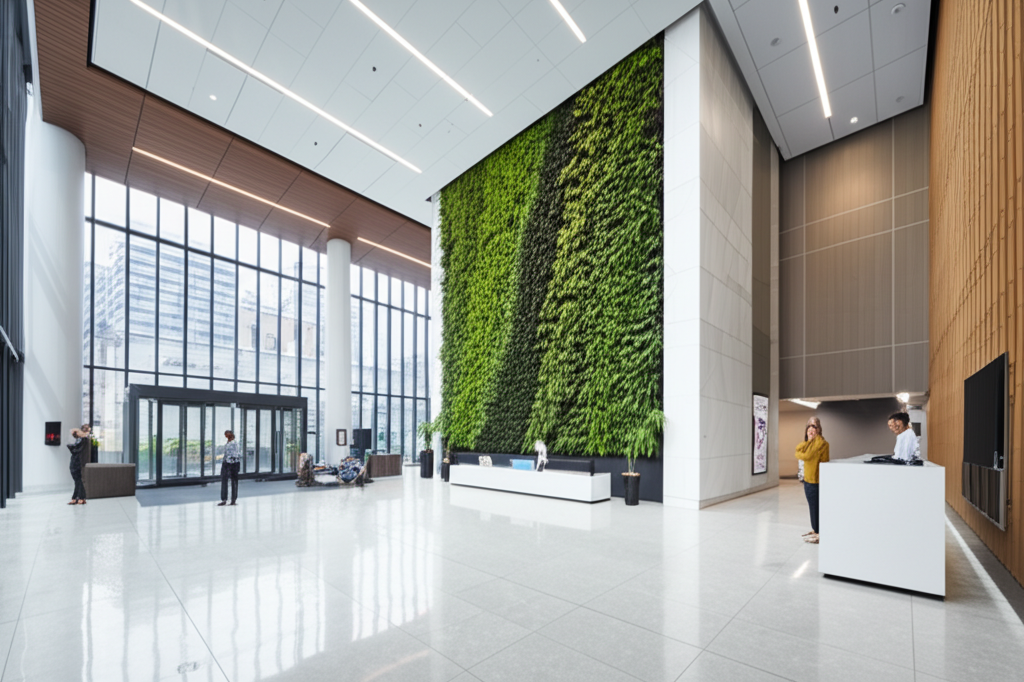

 A spacious, naturally lit lobby featuring floor-to-ceiling windows that flood the space with daylight.  A prominent green wall, lush with vertical plants,  serves as a biophilic focal point and adds a natural contrast to the modern,  clean-lined finishes.  The flooring is light-toned polished stone,  and minimalist lounge seating is arranged in small clusters near the entrance.  Digital welcome signage is mounted near the reception area,  displaying dynamic branded messages.  The space includes subtle architectural lighting integrated into the ceiling,  and the overall palette emphasizes neutral tones with warm wood accents and greenery for a calm,  inviting atmosphere. Make sure to add a few people to make the image more lively and provide sense of scale. 

In [74]:
caption = "Main lobby entrance"
description = """
A spacious, naturally lit lobby featuring floor-to-ceiling windows that flood the space with daylight. 
A prominent green wall, lush with vertical plants, 
serves as a biophilic focal point and adds a natural contrast to the modern, 
clean-lined finishes. 
The flooring is light-toned polished stone, 
and minimalist lounge seating is arranged in small clusters near the entrance. 
Digital welcome signage is mounted near the reception area, 
displaying dynamic branded messages. 
The space includes subtle architectural lighting integrated into the ceiling, 
and the overall palette emphasizes neutral tones with warm wood accents and greenery for a calm, 
inviting atmosphere.
Make sure to add a few people to make the image more lively and provide sense of scale.
"""

img_path = generate_image_and_save(caption, description)
clean_description = description.replace("\n", " ")

if img_path:
    # Display it
    display(Markdown(f"**Figure: {caption}**"))
    display(Image(filename=img_path, width=600))
    display(Markdown(f"{clean_description}"))

## Raw Article Output

After generating the article using few-shot prompting, we scan the content for image placeholders. These will be replaced with contextually relevant, AI-generated images.

In [75]:
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[gen_rag_prompt] 
)
raw_article = response.text.strip()

print(raw_article)
Markdown('---')

# The Intersection of Return-to-Office Design and Workplace Wellness
![A brightly lit, open-plan office space with employees working at desks and in collaborative areas. — This is a wide-angle interior photograph capturing a vibrant and modern open-plan office. Natural light floods the space through large windows, illuminating a variety of workspaces. Some employees are seated at individual desks, while others gather in collaborative zones featuring comfortable seating arrangements. Green plants are strategically placed throughout the office, adding a touch of nature to the environment. The color palette is a mix of neutral tones and bright accents, creating an inviting and energetic atmosphere.](GENERATE_IMAGE)
A brightly lit, open-plan office space with employees working at desks and in collaborative areas.

The return-to-office movement has spurred considerable debate, but one aspect often overlooked is the profound intersection between office design and employee wellness. As organi

---

## Final Article with AI-Generated Visuals

We now apply a helper function that identifies image placeholders within the raw text and inserts the corresponding AI-generated images in the appropriate locations.

In [76]:
import re
def replace_generate_image_markdown(article_text):
    """
    Replaces image placeholders with generated image markdown,
    or removes them entirely if generation fails.
    """
    pattern = re.compile(
        r'!\[(?P<description>.+?)\]\(GENERATE_IMAGE\)\s*\n(?P<caption>[^\n]+)',
        re.MULTILINE
    )

    def replacement(match):
        description = match.group('description').strip()
        caption = match.group('caption').strip()
        # print(f"(Debug) Attempting to generate image for caption: {caption}")

        image_path = generate_image_and_save(caption, description)
        if image_path is None:
            print(f"(Debug) Image generation failed. Removing block for caption: {caption}")
            return ""  # Remove the entire block

        return f"![{description}]({image_path})\n\nCaption: {caption}"

    return pattern.sub(replacement, article_text)

## Displaying the Final Article

We complete the content generation workflow by inserting the AI-generated images into their respective positions and rendering the final output below.

In [77]:
updated_article = replace_generate_image_markdown(raw_article)

In [78]:
display(Markdown('---'))
display(Markdown(updated_article))

---

# The Intersection of Return-to-Office Design and Workplace Wellness
![A brightly lit, open-plan office space with employees working at desks and in collaborative areas. — This is a wide-angle interior photograph capturing a vibrant and modern open-plan office. Natural light floods the space through large windows, illuminating a variety of workspaces. Some employees are seated at individual desks, while others gather in collaborative zones featuring comfortable seating arrangements. Green plants are strategically placed throughout the office, adding a touch of nature to the environment. The color palette is a mix of neutral tones and bright accents, creating an inviting and energetic atmosphere.](generated_406a2b31.png)

Caption: A brightly lit, open-plan office space with employees working at desks and in collaborative areas.

The return-to-office movement has spurred considerable debate, but one aspect often overlooked is the profound intersection between office design and employee wellness. As organizations encourage or mandate a return to physical workspaces, it's crucial to recognize that the design of these spaces directly impacts the well-being of employees. Thoughtful office design can mitigate stress, enhance productivity, and foster a sense of community, thereby contributing to a healthier and more engaged workforce.

## The Wellness-Informed Office: A Holistic Approach

A wellness-informed office transcends mere aesthetics; it embodies a holistic approach that integrates physical, mental, and emotional health considerations into every design decision. It acknowledges that the workplace is not just a site for productivity but a vital component of an employee's overall well-being.

*   **Physical Health:** Ergonomics, air quality, and access to natural light are fundamental. Adjustable desks, supportive chairs, and layouts that encourage movement can alleviate physical strain. Advanced air filtration systems and biophilic design elements, such as indoor plants, enhance air quality and reduce exposure to pollutants.
*   **Mental Health:** Noise levels, visual clutter, and the availability of quiet spaces significantly impact mental well-being. Incorporating sound-absorbing materials, decluttering workspaces, and providing dedicated meditation or relaxation rooms can create a calmer and more focused environment.
*   **Emotional Health:** The design should foster a sense of belonging, connection, and autonomy. Communal areas, collaborative spaces, and opportunities for personalization can cultivate a supportive and inclusive atmosphere.

## Key Design Elements Promoting Wellness

Several design elements play a pivotal role in creating a wellness-focused office. Let's explore these in detail:

### Biophilic Design

![A close-up of a green wall in an office setting, with a variety of plants and natural light. — This is a medium shot capturing a lush green wall in a contemporary office setting. The wall is densely covered with a variety of plants, creating a vibrant and calming visual effect. Soft, natural light filters in from above, highlighting the textures and colors of the foliage. The surrounding décor is minimalist, with clean lines and neutral tones, allowing the green wall to serve as a focal point.](generated_e9a8acf4.png)

Caption: A close-up of a green wall in an office setting, with a variety of plants and natural light.

Biophilic design integrates natural elements into the built environment, recognizing the innate human connection to nature. Studies have shown that exposure to natural light, plants, and natural materials reduces stress, improves mood, and enhances cognitive function.

*   **Natural Light:** Maximize access to sunlight through large windows and skylights. Consider the orientation of workspaces to optimize daylight exposure and minimize glare.
*   **Indoor Plants:** Incorporate plants throughout the office to improve air quality, reduce noise, and create a more visually appealing environment. Consider green walls, potted plants, and hanging planters.
*   **Natural Materials:** Use natural materials such as wood, stone, and bamboo in the design to create a warmer, more inviting atmosphere.

### Ergonomics

![An employee sitting at an adjustable standing desk with proper posture and ergonomic setup. — This is a medium shot of an office worker sitting at a desk, with an emphasis on proper ergonomics. The worker is sitting upright with good posture, using an adjustable chair that supports the lower back. The monitor is positioned at eye level, and the keyboard and mouse are within easy reach. The desk is clean and organized, with minimal clutter. The overall setup promotes comfort and reduces the risk of strain injuries.](generated_17ea3c8a.png)

Caption: An employee sitting at an adjustable standing desk with proper posture and ergonomic setup.

Ergonomics focuses on designing workspaces that fit the human body, reducing the risk of musculoskeletal disorders and promoting comfort.

*   **Adjustable Desks:** Provide employees with adjustable standing desks to encourage movement and reduce sedentary behavior.
*   **Ergonomic Chairs:** Invest in high-quality ergonomic chairs that offer adjustable height, lumbar support, and armrests.
*   **Monitor Placement:** Ensure that computer monitors are positioned at eye level to prevent neck strain.
*   **Keyboard and Mouse:** Provide ergonomic keyboards and mice that support natural hand and wrist positions.

### Activity-Based Workspaces

![A variety of different workspaces in an office, including quiet focus areas, collaborative meeting rooms, and open lounge spaces. — This is a wide-angle shot showcasing a diverse range of workspaces in a modern office. There are quiet focus areas with individual desks, collaborative meeting rooms with large tables, and open lounge spaces with comfortable seating. The layout is designed to support different types of work activities, allowing employees to choose the environment that best suits their needs. The color palette is varied, with a mix of neutral tones and vibrant accents.](generated_b57111fb.png)

Caption: A variety of different workspaces in an office, including quiet focus areas, collaborative meeting rooms, and open lounge spaces.

Recognizing that different tasks require different environments, activity-based workspaces offer a variety of settings to support diverse work styles.

*   **Quiet Zones:** Create dedicated quiet zones for focused work, free from distractions.
*   **Collaboration Spaces:** Provide open and inviting collaboration spaces for team meetings and brainstorming sessions.
*   **Lounge Areas:** Incorporate comfortable lounge areas for relaxation and informal gatherings.
*   **Private Offices:** Offer private offices or enclosed spaces for tasks requiring confidentiality or concentration.

### Technology Integration

![A modern conference room equipped with video conferencing technology, a large display screen, and comfortable seating. — This is a medium shot of a high-tech conference room, showcasing advanced video conferencing equipment. There is a large display screen, a sleek conference table, and comfortable seating for participants. The lighting is soft and diffused, creating a professional and inviting atmosphere. The room is designed to facilitate seamless communication and collaboration among remote and in-person team members.](generated_2c53e763.png)

Caption: A modern conference room equipped with video conferencing technology, a large display screen, and comfortable seating.

Seamless technology integration is essential for supporting hybrid work models and promoting communication and collaboration.

*   **Video Conferencing:** Equip meeting rooms with high-quality video conferencing systems for remote collaboration.
*   **Wireless Connectivity:** Ensure reliable wireless connectivity throughout the office.
*   **Smart Lighting:** Implement smart lighting systems that adjust automatically to optimize natural light and conserve energy.
*   **Digital Signage:** Use digital signage to display important information, announcements, and wayfinding.

## The Business Case for Wellness

Investing in wellness-focused office design is not just a feel-good initiative; it's a strategic business decision that yields tangible benefits.

*   **Increased Productivity:** A healthier and more comfortable work environment leads to increased focus, concentration, and productivity.
*   **Reduced Absenteeism:** Prioritizing employee well-being reduces stress-related illnesses and absenteeism.
*   **Enhanced Employee Engagement:** A supportive and inclusive workplace fosters a sense of belonging, leading to higher employee engagement and retention.
*   **Improved Company Culture:** Wellness-focused design signals a commitment to employee well-being, enhancing the company's reputation and attracting top talent.

## Conclusion

The intersection of return-to-office design and workplace wellness presents a unique opportunity to create spaces that not only facilitate productivity but also nurture the physical, mental, and emotional well-being of employees. By embracing a holistic approach and incorporating key design elements such as biophilic design, ergonomics, activity-based workspaces, and technology integration, organizations can cultivate a healthier, more engaged, and more productive workforce. As the return-to-office movement gains momentum, prioritizing wellness in office design is essential for creating workplaces that support the long-term success and well-being of both employees and the organization as a whole.

# Function Calling for a More Natural User Experience

By leveraging Gemini's multimodal understanding and function calling capabilities, we can integrate all of the previously implemented features—retrieval, generation, and image processing—into a seamless assistant experience.

Before doing so, we’ll organize the utility functions to avoid fragmentation and ensure smooth orchestration.

In [79]:
# Image search, wrapper function to call modularized functions above
def tool_image_search_results(query: str, top_k: int, max_distance: float) -> str:
    """
    Wrapper function that performs a Chroma image search and displays results.
    Internally calls `search_image_chroma` and `display_image_response`.
    """
    # Step 1: Search and filter results
    image_results = search_image_chroma(query=query, top_k=top_k, max_distance=max_distance)

    # Step 2: Display results
    return display_image_response_as_markdown(image_results)

In [105]:
# Article Search, wrapper function to call modularized functions above, tweaked output format
def tool_articles_search_results(query: str, top_k: int, max_distance: float) -> str:
    """
    Wrapper function that uses `search_chroma` to search the article DB,
    and returns a formatted Markdown string of the filtered results.
    """
    # Reuse modular search and filtering logic
    result = search_chroma(query=query, top_k=top_k, max_distance=max_distance)

    markdown_results = []
    for i in range(len(result["documents"][0])):
        doc = result["documents"][0][i]
        meta = result["metadatas"][0][i]
        title = meta.get("title", f"Result {i+1}")
        source = meta.get("source", "#")

        excerpt = doc.strip()[:2000]
        markdown_results.append(
            f"### {i+1}. *{title}*\n\n"
            f"{excerpt}(...)\n\n"
            f"📎 [Read full article]({source})\n\n---"
        )

    return "\n\n".join(markdown_results)

In [91]:
# Image generation, wrapper function calling image generation function + output tweak
def tool_image_generate(caption: str, description: str) -> str:
    """
    Generates an architectural image based on a caption and detailed description.
    Returns: Markdown block with the image and description rendered in notebook.
    """
    from IPython.display import Markdown, Image, display

    # Use wrapper to generate and save the image
    image_path = generate_image_and_save(caption, description)

    if image_path:
        # Display in notebook
        display(Markdown(f"**Figure: {caption}**"))
        display(Image(filename=image_path, width=800))
        display(Markdown(f"*{description}*"))

        return f"🖼️ Image saved and rendered in notebook: `{image_path}`"
    else:
        return "⚠️ Image generation failed."


In [92]:
# RAG generation - Article Summarization
class AnswerWithCitations(TypedDict):
    answer: str
    citations: List[int]

def answer_with_sources(query: str, top_k: int, max_distance: float) -> str:
    """
    Perform a RAG query and structured summarization of database articles.
    Returns markdown-formatted answer with footnotes.
    """
    # Step 1: Retrieve filtered results
    result = search_chroma(query, top_k=top_k)
    keep_indices = [i for i, d in enumerate(result["distances"][0]) if d <= max_distance]

    # Step 2: Build prompt with selected articles
    filtered_result = {k: [[v[0][i] for i in keep_indices]] if isinstance(v, list) and len(v) > 0 and isinstance(v[0], list) else v for k, v in result.items()}
    rag_prompt, structured_articles = build_rag_prompt(system_prompt, query, output_format, result=filtered_result)

    # Step 3: Define schema + config for structured return
    structured_config = types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=AnswerWithCitations,
        temperature=0.1
    )

    # Step 4: Run Gemini generation
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        config=structured_config,
        contents=[rag_prompt]
    )

    structured = response.parsed
    used_ids = set(structured["citations"])

    # Step 5: Format footnotes
    footnotes = "\n".join(
        f"[{a['ref_id']}]: [{a['title']}]({a['url']}) | Relevance: {(1 - a['distance']) * 100:.1f}%  "
        for a in structured_articles if a["ref_id"] in used_ids
    )

    final_output = f"{structured['answer']}\n\n---\n**References**\n\n{footnotes}"
    display(Markdown(final_output))

In [93]:
# RAG generation - Article generation, wrapper function containing modularized functions defined above
def tool_generate_article_with_images(gen_query: str, top_k: int) -> str:
    """
    Generates a thought leadership article using few-shot prompting and inserts images.
    Returns a complete Markdown-formatted article.
    """
    # Step 1: Build few-shot prompt
    gen_rag_prompt = build_few_shot_prompt(gen_sys_prompt, gen_query, gen_output_format, top_k=top_k)

    # Step 2: Generate article content
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=[gen_rag_prompt]
    )
    raw_article = response.text.strip()

    # Step 3: Replace placeholders with image markdown using modular function
    updated_article = replace_generate_image_markdown(raw_article)

    # Step 4: Display and return result
    display(Markdown("---"))
    display(Markdown(updated_article))

    return updated_article    


## Defining the Gemini Assistant

With all core tools now implemented, we define a Gemini Assistant that can dynamically choose which functionality to invoke based on user queries.

In [107]:
tools = [
    tool_articles_search_results,
    tool_image_search_results,
    answer_with_sources,
    tool_generate_article_with_images,
    tool_image_generate,
]
# meta variables to be included in the system instruction prompt
top_k = 5
max_distance_far = 0.99
max_distance_mid = 0.85

instruction = f"""
you're a helpful assitant that can interact with databases
set up in ChromaDB. You will take the user's questions and turn them into queries using the tools available. 
Once you have the information you need, you must use its return value directly in your response without paraphrasing or summarizing it. 
This is very very important.
Always show the full content from the tool result so the user sees the images and article links.

Use {tools[0]} to query articles from the database (When calling the article search tool, 
ALWAYS request at least 5 results using a top_k value of {top_k} and a max_distance of {max_distance_mid} unless the user 
specifies otherwise.). 

Use {tools[1]} to search and display images from the database (When calling the image 
search tool, ALWAYS request at least 5 results using a top_k value of {top_k} and a max_distance of {max_distance_far}
unless the user specifies otherwise.). 

When a user asks for an explanation, summary, analysis, or strategic insight, call the summarize_with_sources tool
(When calling the {tools[2]}, ALWAYS request at least 5 results using a top_k value of {top_k} and a max_distance of {max_distance_mid} 
unless the user specifies otherwise.).This tool will search the article database, retrieve relevant documents, and generate a 
structured answer in the style of bullet points with citations. 
Return the tool output directly without summarizing or rephrasing it.

When the user asks for a new article to be written, use the {tools[3]} tool to generate a thought leadership
article for the AEC industry. (When calling the generate_article_with_images, 
ALWAYS use a top_k value of {top_k} unless the user specifies otherwise.)
This {tools[3]} tool will retrieve relevant articles from a proprietary database as few-shot examples,
Generate a new article using those examples, and Automatically insert well-placed visuals with captions and descriptions. 
Use the tool’s output directly in your response. Do not rewrite, paraphrase, or summarize it. 
If visuals are included, render them inline with their descriptions and captions.
Only use this tool for full article generation requests, not for quick answers or summaries.

When the user requests a new image, call {tools[4]} with their caption and description, do not add any additional text. 
Return only the tool's response, exactly as it was returned, without framing such as "Here is..." or "According to the results...".
Use the output directly in your reply.
"""

chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=tools,
        tool_config=types.ToolConfig(
            function_calling_config={"mode": "auto"}
        )
    ),
)

### Assistant Capabilities

The Gemini Assistant is equipped with the following tools:

#### 1. Image Search
Retrieve relevant visuals from the embedded image database using natural language queries.

In [101]:
query = "Show me images related to office space."
response = chat.send_message(query)
# print(response)
display(Markdown(response.text.strip()))

### Image 1 — *Urban Design’s Renaissance: How San Francisco Is Leading the Way*

![San Francisco Chamber of Commerce Yes SF Workplace & Café, San Francisco. Photo by Jason O’Rear. — The image captures an interior shot of a modern, energetic office space during the daytime, showcasing a design that blends functionality with a touch of urban flair. The room features light wood flooring and white walls contrasted by a dark accent wall with a white-lined map of San Francisco, immediately creating a sense of place. In the background, a screen displays "Yes SF URBAN SUSTAINABILITY CHALLENGE" over an image of the San Francisco skyline, suggesting a meeting or presentation space; attendees are seated in front of the screen on modern light-wood chairs facing a presenter. A woman is working on a laptop at a vibrant red table with matching stools against the dark wall, adding a pop of color to the scene, while other employees are seated at booth-style desks with potted plants, creating a welcoming and dynamic environment.](https://static2.gensler.com/uploads/image/97270/YesSF_07_1743801009.jpg)

**Caption:** San Francisco Chamber of Commerce Yes SF Workplace & Café, San Francisco. Photo by Jason O’Rear. — The image captures an interior shot of a modern, energetic office space during the daytime, showcasing a design that blends functionality with a touch of urban flair. The room features light wood flooring and white walls contrasted by a dark accent wall with a white-lined map of San Francisco, immediately creating a sense of place. In the background, a screen displays "Yes SF URBAN SUSTAINABILITY CHALLENGE" over an image of the San Francisco skyline, suggesting a meeting or presentation space; attendees are seated in front of the screen on modern light-wood chairs facing a presenter. A woman is working on a laptop at a vibrant red table with matching stools against the dark wall, adding a pop of color to the scene, while other employees are seated at booth-style desks with potted plants, creating a welcoming and dynamic environment.  

[From article: *Urban Design’s Renaissance: How San Francisco Is Leading the Way*](https://www.gensler.com/blog/urban-design-renaissance-san-francisco-leading-the-way)

---

### Image 2 — *Redefining the Workplace for a New Era of Productivity and Engagement*

![[Gensler San Francisco](https://www.gensler.com/blog/gensler-san-francisco-future-office-prototype) — This is an eye-level interior photograph of a modern office space, well-lit with natural daylight filtering in, showing a variety of people engaging in work activities at tables and casual areas. The design incorporates warm wood tones on the floor and table tops, contrasted by white walls, ceiling, and exposed ductwork, giving an industrial feel to the minimalist workspace. Long tables on wheels and modern chairs encourage collaboration, while lounge areas with sofas offer more relaxed settings, displaying elements of architecture and interior design with a welcoming and energetic vibe. A display of posters or artwork is mounted on the right wall, adding a touch of branding and visual interest to the office environment.](https://static2.gensler.com/uploads/image/94704/NewWorkplaceEra-GSF02-2000px_1730326755.jpg)

**Caption:** [Gensler San Francisco](https://www.gensler.com/blog/gensler-san-francisco-future-office-prototype) — This is an eye-level interior photograph of a modern office space, well-lit with natural daylight filtering in, showing a variety of people engaging in work activities at tables and casual areas. The design incorporates warm wood tones on the floor and table tops, contrasted by white walls, ceiling, and exposed ductwork, giving an industrial feel to the minimalist workspace. Long tables on wheels and modern chairs encourage collaboration, while lounge areas with sofas offer more relaxed settings, displaying elements of architecture and interior design with a welcoming and energetic vibe. A display of posters or artwork is mounted on the right wall, adding a touch of branding and visual interest to the office environment.  

[From article: *Redefining the Workplace for a New Era of Productivity and Engagement*](https://www.gensler.com/blog/redefining-the-workplace-new-era-of-productivity-engagement)

---

### Image 3 — *Redefining the Workplace for a New Era of Productivity and Engagement*

![[Integrating artificial intelligence in the workplace](https://www.gensler.com/blog/how-ai-is-transforming-workplace-architecture-and-design) is yet another avenue where technology meets human needs. — Here\'s a detailed description of the image:  This is a photograph featuring a person holding a smartphone in their hand, displaying an application related to interior design or space planning. The app shows a floor plan of what seems to be an office space located at "23 Main Street," floor "8". The floor plan includes desks, chairs, and a highlighted area labeled "Huddle 801", which is available now until 10:30 PM for a presentation. The surrounding environment is a modern office space with a mix of industrial and minimalist design elements, including exposed brick walls, black lighting fixtures, and a glass-walled meeting room, suggesting a daytime setting with bright lighting conditions.](https://static1.gensler.com/uploads/image/94701/NewWorkplaceEra-Panda03_1730326215.jpg)

**Caption:** [Integrating artificial intelligence in the workplace](https://www.gensler.com/blog/how-ai-is-transforming-workplace-architecture-and-design) is yet another avenue where technology meets human needs. — Here\'s a detailed description of the image:  This is a photograph featuring a person holding a smartphone in their hand, displaying an application related to interior design or space planning. The app shows a floor plan of what seems to be an office space located at "23 Main Street," floor "8". The floor plan includes desks, chairs, and a highlighted area labeled "Huddle 801", which is available now until 10:30 PM for a presentation. The surrounding environment is a modern office space with a mix of industrial and minimalist design elements, including exposed brick walls, black lighting fixtures, and a glass-walled meeting room, suggesting a daytime setting with bright lighting conditions.  

[From article: *Redefining the Workplace for a New Era of Productivity and Engagement*](https://www.gensler.com/blog/redefining-the-workplace-new-era-of-productivity-engagement)

---

### Image 4 — *Designing Workplaces to Strengthen Connection and Combat Loneliness*

![Gensler San Francisco work cafe and lounge. Photo by Jason O’Rear. — This is a photograph of a modern and bright office space designed with a soft and welcoming style. The open-concept interior features a white ceiling with exposed ductwork and industrial-style lighting, light wood flooring, and a neutral color palette accented with pops of brown and greenery. There is a text in the image "Our favorite places" and some text following it. The space is furnished with comfortable seating, including brown leather chairs and a curved sofa, with people moving around and working in various areas, such as a lounge, a kitchen area with a marble countertop, and glass-enclosed office spaces labelled "Gensler."](https://static1.gensler.com/uploads/image/94521/Gensler_SF_N13_1728938584.jpg)

**Caption:** Gensler San Francisco work cafe and lounge. Photo by Jason O’Rear. — This is a photograph of a modern and bright office space designed with a soft and welcoming style. The open-concept interior features a white ceiling with exposed ductwork and industrial-style lighting, light wood flooring, and a neutral color palette accented with pops of brown and greenery. There is a text in the image "Our favorite places" and some text following it. The space is furnished with comfortable seating, including brown leather chairs and a curved sofa, with people moving around and working in various areas, such as a lounge, a kitchen area with a marble countertop, and glass-enclosed office spaces labelled "Gensler."  

[From article: *Designing Workplaces to Strengthen Connection and Combat Loneliness*](https://www.gensler.com/blog/designing-workplaces-to-combat-loneliness)

---

### Image 5 — *Repopulating the Workplace: Why Collaboration Space Is in Danger*

![Edelman’s Los Angeles office features a variety of casual collaboration areas for coworking and client meetings. The first-floor cafe is dedicated to communal workspaces with multiple seating options — This is an eye-level, interior photograph showcasing a modern and welcoming office lounge area, likely designed by an architecture or interior design firm, during daylight hours with bright lighting. The space includes various seating options such as sofas and chairs in colors like grey, purple, and brown, arranged around sleek, geometric coffee tables and illuminated by modern light fixtures hanging from a ceiling with exposed ductwork. A built-in wall unit features wooden shelves and cabinets, integrated with a TV displaying the "Edelman" logo, complemented by arched doorways and windows offering views of outdoor greenery, contributing to a design that blends modern industrial elements with warm, inviting textures and colors. The image also contains a striped rug.](https://static2.gensler.com/uploads/image/96588/EdelmanLA2023_N11_1739553156.jpg)

**Caption:** Edelman’s Los Angeles office features a variety of casual collaboration areas for coworking and client meetings. The first-floor cafe is dedicated to communal workspaces with multiple seating options — This is an eye-level, interior photograph showcasing a modern and welcoming office lounge area, likely designed by an architecture or interior design firm, during daylight hours with bright lighting. The space includes various seating options such as sofas and chairs in colors like grey, purple, and brown, arranged around sleek, geometric coffee tables and illuminated by modern light fixtures hanging from a ceiling with exposed ductwork. A built-in wall unit features wooden shelves and cabinets, integrated with a TV displaying the "Edelman" logo, complemented by arched doorways and windows offering views of outdoor greenery, contributing to a design that blends modern industrial elements with warm, inviting textures and colors. The image also contains a striped rug.  

[From article: *Repopulating the Workplace: Why Collaboration Space Is in Danger*](https://www.gensler.com/blog/repopulating-the-workplace-collaboration-space-in-danger)

---

#### 2. Article Search
Surface written content from the document collection, filtered by semantic relevance.

In [108]:
query = "show me articles related to mixed use development."
response = chat.send_message(query)
#print(response)
display(Markdown(response.text.strip()))

### 1. *The Future Is Mixed Use: How Principles of Mixed Use Design Will Restore Our Communities*

| Metadata | Value |
|-----|-------|
| title | 'The Future Is Mixed Use: How Principles of Mixed Use Design Will Restore Our Communities' |
| source | 'https://www.gensler.com/blog/how-principles-of-mixed-use-design-will-restore-communities' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 9) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |

# The Future Is Mixed Use: How Principles of Mixed Use Design Will Restore Our Communities
![The Line Charlotte, Charlotte, North Carolina. Photo by Chad Mellon. — This aerial photograph captures a modern architectural complex during the daytime, revealing a city skyline in the background under a clear, bright sky. The design incorporates a sleek, minimalist style with reflective glass towers and a multi-level base featuring open-air parking or terraces, blending aspects of architecture and urban design. The color palette is dominated by neutral tones of gray and reflective glass, creating a contemporary aesthetic. A light rail system runs alongside the building, connecting it to the surrounding urban environment.](https://static2.gensler.com/uploads/image/96187/Hawkins_The_Line_N15_1738016965.jpg)
The Line Charlotte, Charlotte, North Carolina. Photo by Chad Mellon.

The real estate industry is in a time of great uncertainty with volatile inflation and interest rates, rising construction costs, major geopolitical events, and social and economic futures that feel unpredictable. Similar to how the past several years created opportunities to fundamentally rethink how we live, work, and interact with our communities and the built environment, the current upheaval is a chance for us to continue to adapt and innovate.

Amid all the ambiguity, the one type of development that has been thriving is mixed-use environments, which are key to reviving ou(...)

📎 [Read full article](https://www.gensler.com/blog/how-principles-of-mixed-use-design-will-restore-communities)

---

### 2. *The Evolving Role of Hotels in Retail-Driven Mixed-Use Environments*

| Metadata | Value |
|-----|-------|
| title | 'The Evolving Role of Hotels in Retail-Driven Mixed-Use Environments' |
| source | 'https://www.gensler.com/blog/hotels-in-retail-driven-mixed-use-environments' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 9) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |

# The Evolving Role of Hotels in Retail-Driven Mixed-Use Environments
![Fields West, Frisco, Texas — This is a daytime aerial rendering of an urban planning and architecture design. It features a mixture of modern and minimalist buildings of varying heights with a warm and neutral color palette, including tall glass towers, mid-rise structures with greenery on rooftops, and smaller commercial buildings, arranged near a body of water with a walking path and scattered trees. The area appears to be a mixed-use development, with a large parking area and people populating a public space near the water's edge. The rendering indicates a well-lit, energetic environment with a focus on pedestrian accessibility and the integration of nature within the urban landscape.](https://static1.gensler.com/uploads/image/96495/Fields-West_2000x1125_1739229841.jpg)
Fields West, Frisco, Texas

Hotels have long been seen as standalone entities catering primarily to travelers. However, in today’s urban environments, they are increasingly becoming integral parts of retail-driven mixed-use developments.

From integrating retail as an amenity to engaging with the local community and enhancing entertainment experiences, hotels are reshaping the way people interact with other uses around them. As designers, we approach these spaces not just as places of accommodation but as dynamic contributors to a vibrant urban experience.

## Retail as an Amenity: Creating Unique and Curated Experiences

Retail within(...)

📎 [Read full article](https://www.gensler.com/blog/hotels-in-retail-driven-mixed-use-environments)

---

### 3. *5 Ways Suburban Office Campuses Are Transforming Into Thriving Communities*

| Metadata | Value |
|-----|-------|
| title | '5 Ways Suburban Office Campuses Are Transforming Into Thriving Communities' |
| source | 'https://www.gensler.com/blog/5-ways-suburban-office-campuses-are-transforming' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 9) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |

# 5 Ways Suburban Office Campuses Are Transforming Into Thriving Communities
![Park Eight Master Plan, Houston, Texas — This eye-level architectural rendering depicts a modern building complex during daylight, showcasing urban planning and design elements. The main building features a light-colored brick facade with large windows and several terraces, connected to lower structures with glass-enclosed spaces and rooftop gardens. An open green space is filled with people, seating areas, and food trucks, contributing to a vibrant, welcoming atmosphere, while surrounding buildings and clear blue sky complete the scene. The design style leans towards minimalist with a warm color palette featuring wood, brick, and greenery.](https://static2.gensler.com/uploads/image/97287/Park-Eight-Place-Master-Plan_N4_1744052022.jpg)
Park Eight Master Plan, Houston, Texas

Suburban office campuses have come a long way since the highly isolated, sterile, utilitarian environments of the 80s, which were often enveloped by sprawling asphalt parking lots and located miles away from urban centers. If you compare the tenant and program mix of a campus built in the 80s to those built in the last decade, you will see a huge difference in what these campuses are offering to both their tenants and communities.

In the 80s, suburban office campuses typically offered social space and a restaurant or cafe surrounded by a sea of surface parking. To make these dated campuses relevant, developers are in(...)

📎 [Read full article](https://www.gensler.com/blog/5-ways-suburban-office-campuses-are-transforming)

---

### 4. *Trends to Watch: What Other Cities Can Learn From New York City’s Conversion Boom*

| Metadata | Value |
|-----|-------|
| title | 'Trends to Watch: What Other Cities Can Learn From New York City’s Conversion Boom' |
| source | 'https://www.gensler.com/blog/what-cities-can-learn-from-new-york-conversion-boom' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 9) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |

# Trends to Watch: What Other Cities Can Learn From New York City’s Conversion Boom
![Pearl House (160 Water Street), New York, New York. Photo by Robert Deitchler. — This is an eye-level daytime photograph of a modern rooftop terrace featuring several people engaged in leisure activities against the backdrop of a city skyline. The terrace is designed with minimalist grey paving, interspersed with rectangular planters containing lush greenery and small trees. In the foreground, a group of people is gathered around a modern fire pit, while others are relaxing in chairs in the background; the design style blends modern and industrial elements with a welcoming ambiance. The buildings in the background vary in architectural style, and the lighting suggests a sunny day, creating a warm and inviting atmosphere.](https://static1.gensler.com/uploads/image/96222/PearlHouse_160Water_Terrace_02_1738169231.jpg)
Pearl House (160 Water Street), New York, New York. Photo by Robert Deitchler.

*Editor’s Note: This blog is part of our [Design Forecast blog series](https://www.gensler.com/blog/by-keyword?k=Design_Forecast_2025), looking at what’s next in 2025 and beyond.*

As major U.S. cities continue to experience persistently high commercial real estate vacancy rates and severe housing shortages, developers have an opportunity to invest in and convert aging buildings and stranded assets into affordable and market-rate housing, senior living, education facilities, hotels,(...)

📎 [Read full article](https://www.gensler.com/blog/what-cities-can-learn-from-new-york-conversion-boom)

---

### 5. *Trends to Watch Reshaping the Future of Cities and Urban Living*

| Metadata | Value |
|-----|-------|
| title | 'Trends to Watch Reshaping the Future of Cities and Urban Living' |
| source | 'https://www.gensler.com/blog/trends-reshaping-future-of-cities-urban-living' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 9) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |

# Trends to Watch Reshaping the Future of Cities and Urban Living
![A busy street with people and cars. — This image is a photorealistic rendering of an urban street scene, likely for architectural or urban planning design purposes, set during a bright day with natural lighting. The view is at eye level, presenting a modern and welcoming design style. The scene features pedestrians on the sidewalk, vehicles like cars and buses on the street, cyclists, trees, and a distant view of St. Paul's Cathedral, with "160 Fleet Street" visible on a sign. The color palette is warm, with stone buildings and greenery, creating a pleasant and energetic urban environment.](https://static2.gensler.com/uploads/hero_element/23551/thumb_tablet/thumbs/Fleet-Street-area-of-opportunity_1710365013_1024.jpg)
A busy street with people and cars.

*Editor’s Note: This blog is part of our [Design Forecast blog series](https://www.gensler.com/blog/by-keyword?k=Design_Forecast_2024), looking at what’s next in 2024 and beyond. We sat down with [Andre Brumfield](https://www.gensler.com/people/andre-brumfield), [Ian Mulcahey](https://www.gensler.com/people/ian-mulcahey), and [Chris Rzomp](https://www.gensler.com/people/christopher-rzomp), global leaders of Gensler’s [Cities & Urban Design practice](https://www.gensler.com/expertise/cities-urban-design), to discuss what’s next for the future of cities.*

## Many downtowns are struggling in the wake of the pandemic, and clients want to know how to invest effective(...)

📎 [Read full article](https://www.gensler.com/blog/trends-reshaping-future-of-cities-urban-living)

---

#### 3. Image Generation 
Create high-quality, AI-rendered images based on descriptive prompts and metadata.


**Figure: A pedestrian-friendly urban square**

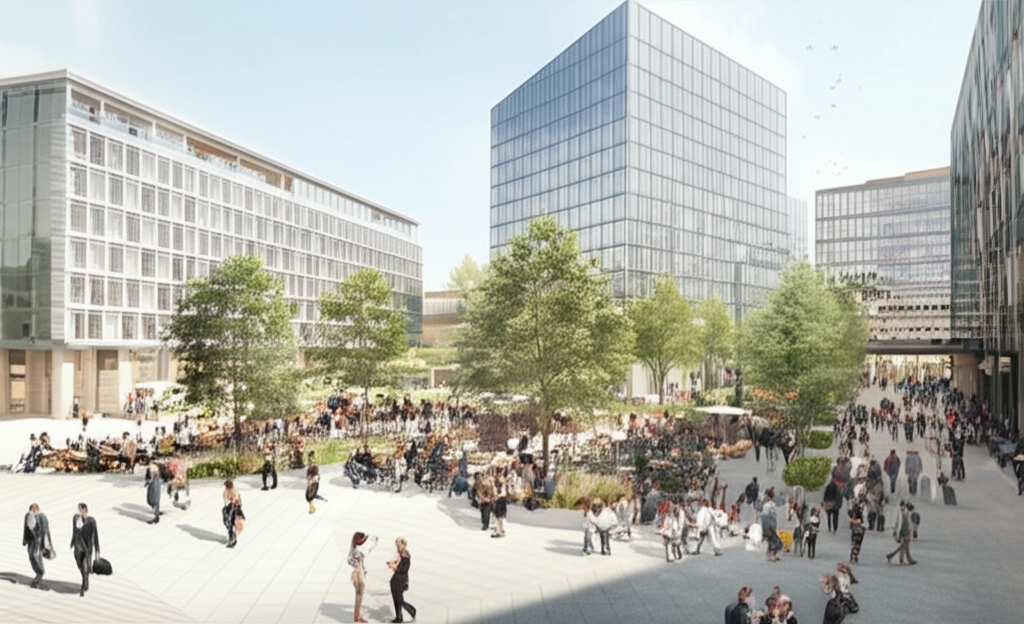

*The square is filled with outdoor restaurants, trees, and people enjoying the space.*

In [87]:
response = chat.send_message("Create an image of a pedestrian-friendly urban square with restaurants and trees.")
display(Markdown(response.text.strip()))

#### 4. RAG – Answer a Question
  Retrieve relevant data and synthesize a structured response with citations.

In [88]:
answer = chat.send_message("Provide me issues to think about when designing for return to office space, also considering workplace survey data.")

When designing a return-to-office space, it's crucial to consider data from workplace surveys to create an environment that meets employee needs and enhances productivity. Gensler's research has uncovered several surprises impacting the return to the office, which can inform design strategies [1].

One key finding is a shift in the primary role of the office. While initially, the main reason for coming to the office was to collaborate in person with colleagues, recent surveys indicate that employees now prioritize the ability to focus on their work [1]. This suggests that the design should incorporate spaces that cater to focused work, such as quiet zones or individual workstations, alongside collaborative areas. Access to technology, specific resources, and scheduled in-person meetings also rank high in importance [1].

Another surprise is that employees feel they need to work in the office more often to maximize their productivity [1]. This highlights a gap between current office utilization and the ideal time needed in the office for productivity, a gap that varies across different countries [2]. To bridge this gap, it's essential to understand what's holding employees back from returning to the office and address those concerns through design [1].

To encourage employees to return, offering a mix of experiences is vital. Gensler's research indicates that providing an ideal work experience mix would motivate a significant percentage of employees to come to the office more often [1]. This involves creating a variety of spaces, from libraries and coffee shops to clubhouses, that cater to different work styles and preferences. Choice in where to work within the office is a fundamental component of a great workplace experience [2]. A balanced workplace should include spaces for creative group work, individual work, reflection and restoration, and connection and recharge [2].

However, it's important to avoid the pitfall of repurposing collaboration spaces into individual workstations to accommodate more employees [3]. While this may seem like a cost-effective solution, it undermines the very purpose of bringing people back to the office: to foster collaboration, interaction, and learning. Instead, organizations should embrace a "both/and" approach, creating environments that support both individual focus work and rich collaborative work [3].

Furthermore, thoughtful workplace design should address the diverse needs of employees and their well-being to deliver a better workplace experience, which in turn leads to more engagement and productivity [4]. This includes creating engaging environments with various space types to accommodate different work modes, as well as establishing a sense of belonging by accommodating the needs of all employees [4]. By prioritizing these principles, organizations can create workplaces that not only enhance productivity but also promote employee happiness and fulfillment [4].

---
**References**

[1]: [3 Surprises Impacting the Return to the Office](https://www.gensler.com/blog/3-surprises-impacting-the-return-to-the-office) | Relevance: 31.4%  
[2]: [Global Workplace Survey Comparison 2023](https://www.gensler.com/gri/global-workplace-survey-comparison-2023) | Relevance: 22.4%  
[3]: [Repopulating the Workplace: Why Collaboration Space Is in Danger](https://www.gensler.com/blog/repopulating-the-workplace-collaboration-space-in-danger) | Relevance: 21.3%  
[4]: [Designing Workplaces to Strengthen Connection and Combat Loneliness](https://www.gensler.com/blog/designing-workplaces-to-combat-loneliness) | Relevance: 17.0%  

#### 5. RAG – Generate an Article 
Compose a full-length, contextually grounded article using few-shot prompting and multimodal context.

In [89]:
article = chat.send_message("Generate a thought leadership article using data from workplace survey to help backup new return-to-office considerations.")

---

# Leveraging Workplace Survey Data for a Successful Return to Office

![A diverse group of colleagues collaborates in a modern office space, gathering around a table to review documents and discuss ideas. The setting is bright and open, with large windows providing natural light.](generated_53920fc4.png)

Caption: A diverse group of colleagues collaborates in a modern office space.

The return to the office (RTO) has become a critical topic for organizations worldwide. As companies navigate the complexities of hybrid work models, understanding employee sentiment and preferences is paramount. Workplace surveys offer a powerful tool for gathering this crucial data, enabling informed decision-making and a smoother transition. This article explores how organizations can leverage workplace survey data to optimize their RTO strategies, focusing on key considerations such as identifying employee needs, addressing concerns, and creating a compelling office environment.

## Understanding Employee Needs and Concerns

The first step in leveraging workplace survey data is to identify the primary needs and concerns of employees regarding the RTO. Surveys can reveal valuable insights into:

*   **Preferred work arrangements:** Do employees prefer a fully remote, hybrid, or fully in-office model?
*   **Reasons for resistance:** What are the main reasons some employees are hesitant to return? (e.g., commute time, childcare issues, health concerns).
*   **Support needs:** What kind of support do employees need to make a successful transition back to the office? (e.g., flexible schedules, childcare assistance, improved technology).

![A bar graph depicting employee preferences for different work arrangements, showing the percentage of employees who prefer remote, hybrid, and in-office work models.](generated_9d03299c.png)

Caption: Employee preferences for work arrangements.

Analyzing the survey data helps organizations understand the diverse needs of their workforce. For instance, a survey might reveal that while a majority of employees appreciate the flexibility of hybrid work, a significant portion also miss the in-person collaboration and social interaction that the office provides.

## Addressing Employee Concerns and Building Trust

Once the key concerns are identified, organizations need to develop strategies to address them effectively. This may involve:

*   **Communicating transparently:** Share the survey findings with employees and explain how their feedback is being used to shape the RTO strategy.
*   **Offering flexible options:** Implement flexible work arrangements that accommodate individual needs and preferences, where possible.
*   **Prioritizing health and safety:** Clearly communicate the measures being taken to ensure a safe and healthy work environment, such as enhanced cleaning protocols and improved ventilation.

![An infographic outlining the steps an organization is taking to address employee concerns about returning to the office, including enhanced cleaning protocols, flexible work arrangements, and improved communication.](generated_b2cc275c.png)

Caption: An infographic outlining steps to address employee concerns.

By addressing employee concerns and demonstrating a commitment to their well-being, organizations can build trust and foster a more positive attitude towards the RTO.

## Creating a Compelling Office Environment

Beyond addressing concerns, organizations should also focus on making the office a more attractive and productive place to work. Workplace surveys can provide insights into:

*   **Desired office amenities:** What amenities would encourage employees to come to the office more often? (e.g., improved cafeteria, fitness center, collaborative spaces).
*   **Technology needs:** What technology upgrades are needed to support seamless hybrid work? (e.g., improved video conferencing equipment, collaboration tools).
*   **Workspace design:** How can the office layout be optimized to support different types of work activities? (e.g., quiet zones for focused work, collaborative spaces for team projects).

![A rendering of a redesigned office space featuring a mix of collaborative areas, individual workstations, and recreational amenities, based on employee feedback from a workplace survey.](generated_3426fa19.png)

Caption: A rendering of a redesigned office space.

By investing in the right amenities, technology, and workspace design, organizations can create a compelling office environment that supports both individual and team productivity, as well as fostering a sense of community and belonging.

## Continuous Improvement and Adaptation

The RTO is not a one-time event, but rather an ongoing process of adaptation and improvement. Organizations should continue to monitor employee sentiment through regular surveys and feedback sessions, and be prepared to adjust their strategies as needed.

*   **Regular check-ins:** Conduct frequent pulse surveys to gauge employee satisfaction with the RTO process and identify any emerging issues.
*   **Feedback mechanisms:** Establish channels for employees to provide ongoing feedback and suggestions for improvement.
*   **Data-driven decisions:** Use the data collected to inform future decisions about workplace policies, design, and technology.

![A flowchart illustrating the continuous improvement cycle for return-to-office strategies, emphasizing the importance of data collection, analysis, implementation, and evaluation.](generated_e870a7ed.png)

Caption: A flowchart illustrating the continuous improvement cycle.

By embracing a data-driven approach and continuously seeking feedback, organizations can ensure that their RTO strategies remain aligned with the evolving needs of their workforce and contribute to a more productive, engaged, and satisfied employee experience.

## Use Cases

This system has the potential to transform how AEC professionals access and apply collective knowledge:
- Instant Answers in Reviews: Retrieve precedents, design details, or research findings on the fly during meetings (e.g., “Show examples of sustainable facades from recent projects”).
- Data-Driven Planning: Surface past project metrics (e.g., cost per square foot, circulation ratios) to guide feasibility and early-stage design.
- Content Generation: Support proposal writing and thought leadership with relevant internal knowledge, ensuring consistency and efficiency.
- Team Onboarding: Help new or junior staff explore firm standards and precedents independently, speeding up knowledge transfer.


## Acknowledgement and Opportunities

While this proof-of-concept demonstrates strong potential, several improvements could enhance production readiness:
- Robust Ingestion: Support diverse formats like PDFs, BIM exports, scanned documents, and internal wikis.
- Smarter Embedding: Apply chunking, metadata-aware models, or Doc2Vec-style techniques for richer context representation.
- Improved Retrieval: Add relevance ranking, filters, and support for live queries via secure API connections.
- UX Enhancements: Build a dedicated web/app interface with visual-first outputs and structured citations.


## What’s Next

Future iterations will focus on scaling and refining the system:
- Smarter Retrieval: Add ranking, filtering, and support for diverse formats like PDFs and BIM exports.
- Advanced Embeddings: Use models that capture document structure and merge image + text inputs.
- Conversational AI: Enable multi-step reasoning and live data access via APIs.
- Better UX: Build a visual-first interface with structured output and citations.

This project shows how Gen-AI—especially RAG and multimodal capabilities—can help overcome data fragmentation in the AEC industry. By making buried knowledge accessible and searchable, systems like this can support smarter planning, faster decision-making, and more effective design and delivery.